# LATENT-BASED IMPUTATION OF MISSING VALUES

## Description of this notebook

This notebook imputes the missing data using Latent Variable Models (LVMs).

In [ ]:
# Load all the necessary libraries

import pandas as pd
import numpy as np
from GPy import models
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings("ignore")
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
import itertools
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
# os.chdir('..') # move to the general directory

In [ ]:
# Load the data
data_complete = pd.read_csv('DATA/input_DATA_NO_NAs_INPUT.csv')
data_incomplete = pd.read_csv('DATA/data.csv').drop(columns=['ADAS13'])

In [ ]:
# Load the subsets of features
subject_details = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4']
fdg_pet = ['AngularLeft', 'AngularRight', 'CingulumPostBilateral', 'TemporalLeft', 'TemporalRight']
nepb = ['MMSE', 'RAVLT_learning', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'FAQ']
av_45 = ['CEREBELLUMGREYMATTER_UCBERKELEYAV45_10_17_16', 'WHOLECEREBELLUM_UCBERKELEYAV45_10_17_16', 'ERODED_SUBCORTICALWM_UCBERKELEYAV45_10_17_16', 'FRONTAL_UCBERKELEYAV45_10_17_16', 
               'CINGULATE_UCBERKELEYAV45_10_17_16', 'PARIETAL_UCBERKELEYAV45_10_17_16', 'TEMPORAL_UCBERKELEYAV45_10_17_16']
csf_values = ['ABETA_UPENNBIOMK9_04_19_17', 'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17']
mri = ['Hippocampus', 'WholeBrain', 'Ventricles', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

groups = [subject_details, fdg_pet, nepb, av_45, csf_values, mri]
group_names = ['subject_details', 'fdg_pet', 'nepb', 'av_45', 'csf_values', 'mri']

In [ ]:
# Store the masks identifying missing values for all the cases
data_complete_missing_mask = data_complete.isna().values
original_missing_mask = data_incomplete.isna().values
original_missing_mask_sd = data_incomplete[subject_details].isna().values
original_missing_mask_fdg = data_incomplete[fdg_pet].isna().values
original_missing_mask_nepb = data_incomplete[nepb].isna().values
original_missing_mask_av45 = data_incomplete[av_45].isna().values
original_missing_mask_csf = data_incomplete[csf_values].isna().values
original_missing_mask_mri = data_incomplete[mri].isna().values

## **1.** GPLVM Imputation

### **Overall Performance**

In [ ]:
# This function calculates the overall performance obtained when imputing missing values using GPLVM models
def crossval_imputation_performance(data, original_missing_mask, input_dim=2, n_splits=10, missing_rate=0.2):
    r2_scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold = 1
    for train_index, test_index in kf.split(data):
        # Divide the data
        train_data = data.iloc[train_index].copy()
        test_data = data.iloc[test_index].copy()

        # Create a mask identifying the positions of the synthetic NAs
        train_known_mask = ~original_missing_mask[train_index]
        test_known_mask = ~original_missing_mask[test_index]

        # Introduce the synthetic NAs in the defined positions
        total_known_values = np.sum(test_known_mask)
        missing_count = int(total_known_values * missing_rate)
        possible_indices = np.argwhere(test_known_mask)
        selected_indices = possible_indices[np.random.choice(len(possible_indices), missing_count, replace=False)]
        data_test_missing = test_data.copy()
        data_test_missing.values[selected_indices[:,0], selected_indices[:,1]] = np.nan

        # Train the model using only the training data
        imputer = models.BayesianGPLVM(Y=np.array(train_data), input_dim=input_dim, init='PCA')
        imputer.optimize()

        # Impute the masked values
        missing_mask = np.isnan(data_test_missing)
        rows_with_missing = np.any(missing_mask, axis=1)
        missing_row_indices = np.where(rows_with_missing)[0]
        X_missing = imputer.X.mean[missing_row_indices]
        mu_pred, var_pred = imputer.predict(X_missing)
        filled = data_test_missing.values.copy()
        filled[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, filled[rows_with_missing])
        data_imputed = pd.DataFrame(filled, columns=data.columns)

        # Store the true values and the imputed values in the masked positions
        true_values = test_data.values[selected_indices[:,0], selected_indices[:,1]]
        imputed_values = data_imputed.values[selected_indices[:,0], selected_indices[:,1]]

        # Compute the r2 score
        r2 = r2_score(true_values, imputed_values)
        r2_scores.append(r2)
        print(f'Fold {fold}: R2 = {(r2):.3f}')
        fold += 1

    # Return the final metrics
    return (f"CV R2: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

### **Subset Performance**

In [ ]:
# This function calculates the performance obtained when imputing missing values in specific subsets using GPLVM models

def evaluate_imputation_gplvm_groups(data, original_missing_mask, groups, group_names, n_splits=10, missing_rate=0.2):
    group_r2_scores_gplvm = {name: [] for name in group_names}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(data), start=1):
        print(f'Fold {fold}')

        # Divide the data
        train_data = data.iloc[train_idx].copy()
        test_data = data.iloc[test_idx].copy()
        test_missing_mask = original_missing_mask[test_idx]

        # Train the model using the train data
        imputer = models.BayesianGPLVM(Y=np.array(train_data), input_dim=2, init='PCA')
        imputer.optimize()

        # Impute the masked positions in test set for each group
        for group, name in zip(groups, group_names):
            
            print(f'Imputando grupo: {name}')

            # Decide the positions of the entries in the test set that will be masked
            data_test_group = test_data[group].copy()
            group_indices = [data.columns.get_loc(col) for col in group]
            test_known_mask = ~test_missing_mask[:, group_indices]
            total_known_values = np.sum(test_known_mask)
            missing_count = int(total_known_values * missing_rate)
            possible_indices = np.argwhere(test_known_mask)
            selected_indices = possible_indices[np.random.choice(len(possible_indices), missing_count, replace=False)]

            # Mask the decided positions
            data_test_missing = data_test_group.copy()
            data_test_missing.values[selected_indices[:,0], selected_indices[:,1]] = np.nan
            missing_mask = np.isnan(data_test_missing.values)
            rows_with_missing = np.any(missing_mask, axis=1)
            missing_row_indices = np.where(rows_with_missing)[0]

            # Predict and impute the masked values
            X_missing = imputer.X.mean[missing_row_indices]
            mu_pred_rows, _ = imputer.predict(X_missing)
            mu_pred_group = mu_pred_rows[:, group_indices]
            filled = data_test_missing.values.copy()
            filled[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred_group, filled[rows_with_missing])
            data_imputed = pd.DataFrame(filled, columns=group)

            # Store the true and imputed values at the masked positions
            true_values = data_test_group.values[selected_indices[:,0], selected_indices[:,1]]
            imputed_values = data_imputed.values[selected_indices[:,0], selected_indices[:,1]]

            # Compute the r2 score
            r2 = r2_score(true_values, imputed_values)
            group_r2_scores_gplvm[name].append(r2)
            print(f'    R2 = {r2:.3f}')

    # Return the final results
    print("\n--- Resultados finales ---")
    for name in group_names:
        scores = group_r2_scores_gplvm[name]
        if scores:
            print(f"Overall R2 {name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
        else:
            print(f"Overall R2 {name}: N/A")
        print('---------------------------------------------')

    return group_r2_scores_gplvm


### Latent Dimension

In [ ]:
for dim in range(2, 11):
    print(f'Latent Dimension {dim}')
    print(crossval_imputation_performance(data=data_complete, original_missing_mask=data_complete_missing_mask, input_dim=dim))

Latent Dimension 2
Fold 1: R2 = 0.988
Fold 2: R2 = 0.980
Fold 3: R2 = 0.990
Fold 4: R2 = 0.983
Fold 5: R2 = 0.985
Fold 6: R2 = 0.981
Fold 7: R2 = 0.983
Fold 8: R2 = 0.979
Fold 9: R2 = 0.982
Fold 10: R2 = 0.992
CV R2: 0.984 ± 0.004
Latent Dimension 3
Fold 1: R2 = 0.979
Fold 2: R2 = 0.976
Fold 3: R2 = 0.988
Fold 4: R2 = 0.973
Fold 5: R2 = 0.986
Fold 6: R2 = 0.963
Fold 7: R2 = 0.974
Fold 8: R2 = 0.976
Fold 9: R2 = 0.969
Fold 10: R2 = 0.984
CV R2: 0.977 ± 0.007
Latent Dimension 4
Fold 1: R2 = 0.978
Fold 2: R2 = 0.978
Fold 3: R2 = 0.991
Fold 4: R2 = 0.979
Fold 5: R2 = 0.986
Fold 6: R2 = 0.989
Fold 7: R2 = 0.970
Fold 8: R2 = 0.977
Fold 9: R2 = 0.974
Fold 10: R2 = 0.966
CV R2: 0.979 ± 0.008
Latent Dimension 5
Fold 1: R2 = 0.983
Fold 2: R2 = 0.969
Fold 3: R2 = 0.979
Fold 4: R2 = 0.973
Fold 5: R2 = 0.985
Fold 6: R2 = 0.986
Fold 7: R2 = 0.961
Fold 8: R2 = 0.975
Fold 9: R2 = 0.975
Fold 10: R2 = 0.974
CV R2: 0.976 ± 0.007
Latent Dimension 6
Fold 1: R2 = 0.979
Fold 2: R2 = 0.987
Fold 3: R2 = 0.982


### Scaling the Data

In [ ]:
# Separate the categorical and numerical variables
input_cat = data_complete[['PTGENDER', 'APOE4']]
input_num = data_complete.drop(columns=['PTGENDER', 'APOE4'])


# Scale the data 
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_num)
input_scaled = pd.DataFrame(input_scaled, columns=input_num.columns)

# Concatenate scaled data with categorical variables
input = pd.concat([input_scaled, input_cat], axis=1)

In [ ]:
crossval_imputation_performance(data=input, original_missing_mask=data_complete_missing_mask)

Fold 1: R2 = -0.462
Fold 2: R2 = -0.354
Fold 3: R2 = -0.240
Fold 4: R2 = -0.404
Fold 5: R2 = -0.499
Fold 6: R2 = -0.473
Fold 7: R2 = -0.416
Fold 8: R2 = -0.613
Fold 9: R2 = -0.620
Fold 10: R2 = -0.524


'CV R2: -0.460 ± 0.109'

### **Training Single Model**

#### **1.1** Pre-Imputed Mean

##### Performance Evaluation

In [ ]:
# Training and testing overall performance on the complete observed data

mean_data = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
crossval_imputation_performance(data=mean_data, original_missing_mask=original_missing_mask)

Fold 1: R2 = 0.972
Fold 2: R2 = 0.981
Fold 3: R2 = 0.978
Fold 4: R2 = 0.978
Fold 5: R2 = 0.967
Fold 6: R2 = 0.971
Fold 7: R2 = 0.983
Fold 8: R2 = 0.961
Fold 9: R2 = 0.970
Fold 10: R2 = 0.970


'CV R2: 0.973 ± 0.006'

In [ ]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data=mean_data, original_missing_mask=original_missing_mask, groups=groups, group_names=group_names)

Fold 1
  Imputando grupo: subject_details
    R2 = 0.970
  Imputando grupo: fdg_pet
    R2 = -0.584
  Imputando grupo: nepb
    R2 = 0.485
  Imputando grupo: av_45
    R2 = 0.462
  Imputando grupo: csf_values
    R2 = 0.655
  Imputando grupo: mri
    R2 = 0.953
Fold 2
  Imputando grupo: subject_details
    R2 = 0.961
  Imputando grupo: fdg_pet
    R2 = -0.014
  Imputando grupo: nepb
    R2 = 0.637
  Imputando grupo: av_45
    R2 = 0.534
  Imputando grupo: csf_values
    R2 = 0.531
  Imputando grupo: mri
    R2 = 0.971
Fold 3
  Imputando grupo: subject_details
    R2 = 0.984
  Imputando grupo: fdg_pet
    R2 = -0.031
  Imputando grupo: nepb
    R2 = 0.501
  Imputando grupo: av_45
    R2 = 0.547
  Imputando grupo: csf_values
    R2 = 0.440
  Imputando grupo: mri
    R2 = 0.968
Fold 4
  Imputando grupo: subject_details
    R2 = 0.972
  Imputando grupo: fdg_pet
    R2 = -0.406
  Imputando grupo: nepb
    R2 = 0.522
  Imputando grupo: av_45
    R2 = 0.382
  Imputando grupo: csf_values
    R

{'subject_details': [0.9700094203013214,
  0.9608108533363312,
  0.984197878303749,
  0.9715974001071519,
  0.9750277156833975,
  0.9796220251904321,
  0.9681636524450884,
  0.9699656168730414,
  0.975209886894194,
  0.9649346664161812],
 'fdg_pet': [-0.5843150809765598,
  -0.014372517791723771,
  -0.030691508210139773,
  -0.4056342442231673,
  -0.35177076262730655,
  -0.08520846977397656,
  -0.15589127580757012,
  -0.04872354656384714,
  -0.23411562258053098,
  -0.23831907011516074],
 'nepb': [0.48509934971398994,
  0.6372796316776781,
  0.5011301777698787,
  0.5217202996172081,
  0.48888690165348014,
  0.6541148672083847,
  0.5032944042806273,
  0.6015343069801753,
  0.6165376989127324,
  0.6258226686617564],
 'av_45': [0.461954086497979,
  0.533867962567095,
  0.5467751655361233,
  0.38240054971073567,
  0.3845641175061204,
  0.5843771497054928,
  0.460260838308013,
  0.518744186366646,
  0.5243421328256008,
  0.4873574061600492],
 'csf_values': [0.655456292790344,
  0.5314029196789

##### Create Imputed Dataset

In [ ]:
d = 2

gplvm_mean = models.BayesianGPLVM(Y=np.array(mean_data), input_dim=d, init='PCA')
gplvm_mean.optimize()

In [ ]:
joblib.dump(gplvm_mean, 'FINAL MODELS/gplvm_mean.pkl')

['FINAL MODELS/gplvm_mean.pkl']

In [ ]:
imputed_mean = data_incomplete.copy()

missing_mask = np.isnan(imputed_mean) # mask the missing values
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mean.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mean.predict(X_missing) # predict the missing values using the trained model
imputed_mean.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_mean.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
latent1 = pd.DataFrame(gplvm_mean.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mean.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean = pd.concat([latent1, latent2], axis=1)
latent_mean.to_csv('GPLVM IMPUTATION/latent_mean_df.csv', index=False)

#### **1.2** Pre-Imputed Median

##### Performance Evaluation

In [ ]:
# Training and testing overall performance on the complete observed data

median_data = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
crossval_imputation_performance(data=median_data, original_missing_mask=original_missing_mask)

Fold 1: R2 = 0.971
Fold 2: R2 = 0.981
Fold 3: R2 = 0.968
Fold 4: R2 = 0.977
Fold 5: R2 = 0.977
Fold 6: R2 = 0.974
Fold 7: R2 = 0.980
Fold 8: R2 = 0.972
Fold 9: R2 = 0.976
Fold 10: R2 = 0.974


'CV R2: 0.975 ± 0.004'

In [ ]:
# Testing overall performance on complete subsets of features
median_data = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
evaluate_imputation_gplvm_groups(data=median_data, original_missing_mask=original_missing_mask, groups=groups, group_names=group_names)

Fold 1
  Imputando grupo: subject_details
    R2 = 0.971
  Imputando grupo: fdg_pet
    R2 = -0.673
  Imputando grupo: nepb
    R2 = 0.534
  Imputando grupo: av_45
    R2 = 0.408
  Imputando grupo: csf_values
    R2 = 0.632
  Imputando grupo: mri
    R2 = 0.971
Fold 2
  Imputando grupo: subject_details
    R2 = 0.981
  Imputando grupo: fdg_pet
    R2 = 0.024
  Imputando grupo: nepb
    R2 = 0.501
  Imputando grupo: av_45
    R2 = 0.614
  Imputando grupo: csf_values
    R2 = 0.464
  Imputando grupo: mri
    R2 = 0.965
Fold 3
  Imputando grupo: subject_details
    R2 = 0.978
  Imputando grupo: fdg_pet
    R2 = -0.106
  Imputando grupo: nepb
    R2 = 0.572
  Imputando grupo: av_45
    R2 = 0.352
  Imputando grupo: csf_values
    R2 = 0.478
  Imputando grupo: mri
    R2 = 0.957
Fold 4
  Imputando grupo: subject_details
    R2 = 0.967
  Imputando grupo: fdg_pet
    R2 = -0.167
  Imputando grupo: nepb
    R2 = 0.450
  Imputando grupo: av_45
    R2 = 0.507
  Imputando grupo: csf_values
    R2

{'subject_details': [0.9713056845620043,
  0.9813391824309682,
  0.9777577784576139,
  0.9674754554425655,
  0.9666522257665173,
  0.9845836713436005,
  0.9802566160030637,
  0.9719847304477531,
  0.9780268617986086,
  0.9815316318652466],
 'fdg_pet': [-0.6732499677108583,
  0.02367529249599576,
  -0.10604252967450134,
  -0.1674540320418585,
  -0.6367217859974577,
  -0.18446564936718812,
  -0.20255772623874813,
  -0.10630589424761605,
  -0.17344186660433092,
  0.12696967377902402],
 'nepb': [0.534274820686178,
  0.5006117961374681,
  0.5718197110941607,
  0.4497603680672433,
  0.47158239398530666,
  0.6238827747907003,
  0.5176651408569672,
  0.4921528616432219,
  0.5584992916016924,
  0.5282188928497777],
 'av_45': [0.40772873798915354,
  0.6137252902364592,
  0.35244925690174955,
  0.5066679080611375,
  0.326323562269243,
  0.5551848533737749,
  0.4478353157513687,
  0.3353414771204952,
  0.6532657359317507,
  0.33849323465895875],
 'csf_values': [0.6323125102200498,
  0.464354651258

##### Create Imputed Dataset

In [ ]:
d = 2

gplvm_median = models.BayesianGPLVM(Y=np.array(median_data), input_dim=d, init='PCA')
gplvm_median.optimize()

In [ ]:
joblib.dump(gplvm_median, 'FINAL MODELS/gplvm_median.pkl')

['FINAL MODELS/gplvm_median.pkl']

In [ ]:
imputed_median = data_incomplete.copy()

missing_mask = np.isnan(imputed_median) # mask the missing values
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_median.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_median.predict(X_missing) # predict the missing values using the trained model
imputed_median.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_median.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
latent1 = pd.DataFrame(gplvm_median.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_median.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median = pd.concat([latent1, latent2], axis=1)
latent_median.to_csv('GPLVM IMPUTATION/latent_median_df.csv', index=False)

#### **1.3** Pre-Imputed Mode

##### Performance Evaluation

In [ ]:
# Training and testing overall performance on the complete observed data

mode_data = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
crossval_imputation_performance(data=mode_data, original_missing_mask=original_missing_mask)

Fold 1: R2 = 0.970
Fold 2: R2 = 0.975
Fold 3: R2 = 0.976
Fold 4: R2 = 0.975
Fold 5: R2 = 0.968
Fold 6: R2 = 0.978
Fold 7: R2 = 0.978
Fold 8: R2 = 0.977
Fold 9: R2 = 0.974
Fold 10: R2 = 0.973


'CV R2: 0.975 ± 0.003'

In [ ]:
# Testing overall performance on complete subsets of features
mode_data = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

evaluate_imputation_gplvm_groups(data=mode_data, original_missing_mask=original_missing_mask, groups=groups, group_names=group_names)

Fold 1
  Imputando grupo: subject_details
    R2 = 0.987
  Imputando grupo: fdg_pet
    R2 = -0.391
  Imputando grupo: nepb
    R2 = 0.471
  Imputando grupo: av_45
    R2 = 0.458
  Imputando grupo: csf_values
    R2 = 0.541
  Imputando grupo: mri
    R2 = 0.972
Fold 2
  Imputando grupo: subject_details
    R2 = 0.970
  Imputando grupo: fdg_pet
    R2 = -0.235
  Imputando grupo: nepb
    R2 = 0.650
  Imputando grupo: av_45
    R2 = 0.360
  Imputando grupo: csf_values
    R2 = 0.599
  Imputando grupo: mri
    R2 = 0.978
Fold 3
  Imputando grupo: subject_details
    R2 = 0.988
  Imputando grupo: fdg_pet
    R2 = -0.072
  Imputando grupo: nepb
    R2 = 0.575
  Imputando grupo: av_45
    R2 = 0.413
  Imputando grupo: csf_values
    R2 = 0.640
  Imputando grupo: mri
    R2 = 0.970
Fold 4
  Imputando grupo: subject_details
    R2 = 0.980
  Imputando grupo: fdg_pet
    R2 = -0.140
  Imputando grupo: nepb
    R2 = 0.484
  Imputando grupo: av_45
    R2 = 0.324
  Imputando grupo: csf_values
    R

{'subject_details': [0.9874718205472929,
  0.9696196463694402,
  0.9883408827843501,
  0.9798457276890559,
  0.9815905869453453,
  0.9697773854429621,
  0.9755641043286584,
  0.9561138148831912,
  0.9729610193450863,
  0.9814797077840066],
 'fdg_pet': [-0.39063659588466293,
  -0.23501971272580313,
  -0.07168387125326481,
  -0.1399624334723948,
  -0.17340628289655036,
  -0.39977781885424757,
  -0.5028391055576658,
  -0.3922247935364178,
  -0.24709357643496843,
  -0.18007322058780217],
 'nepb': [0.4705051847267323,
  0.6499179288149719,
  0.5746664262383276,
  0.4839894543369898,
  0.5948648506645079,
  0.5805948428722324,
  0.5256116067955624,
  0.41134113016782814,
  0.5576401483813967,
  0.6974197676092854],
 'av_45': [0.4579613572885788,
  0.3604573625029349,
  0.4132073611201347,
  0.32435326666329345,
  0.3086773779054306,
  0.43364580048304247,
  0.27370018832120535,
  0.35488579155424105,
  0.5354159000213847,
  0.264315913185897],
 'csf_values': [0.5409565884107961,
  0.59928934

##### Create Imputed Dataset

In [ ]:
d = 2

gplvm_mode = models.BayesianGPLVM(Y=np.array(mode_data), input_dim=d, init='PCA')
gplvm_mode.optimize()

In [ ]:
joblib.dump(gplvm_mode, 'FINAL MODELS/gplvm_mode.pkl')

['FINAL MODELS/gplvm_mode.pkl']

In [ ]:
imputed_mode = data_incomplete.copy()

missing_mask = np.isnan(imputed_mode) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mode.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mode.predict(X_missing) # predict the missing values using the trained model
imputed_mode.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_mode.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
latent1 = pd.DataFrame(gplvm_mode.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mode.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode = pd.concat([latent1, latent2], axis=1)
latent_mode.to_csv('GPLVM IMPUTATION/latent_mode_df.csv', index=False)

#### **1.4** Pre-Imputed KNN

##### Performance Evaluation

In [ ]:
# Training and testing overall performance on the complete observed data

knn_data = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
crossval_imputation_performance(data=knn_data, original_missing_mask=original_missing_mask)

Fold 1: R2 = 0.971
Fold 2: R2 = 0.977
Fold 3: R2 = 0.968
Fold 4: R2 = 0.983
Fold 5: R2 = 0.977
Fold 6: R2 = 0.977
Fold 7: R2 = 0.978
Fold 8: R2 = 0.968
Fold 9: R2 = 0.975
Fold 10: R2 = 0.975


'CV R2: 0.975 ± 0.004'

In [ ]:
# Testing overall performance on complete subsets of features
knn_data = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

evaluate_imputation_gplvm_groups(data=knn_data, original_missing_mask=original_missing_mask, groups=groups, group_names=group_names)

Fold 1
  Imputando grupo: subject_details
    R2 = 0.980
  Imputando grupo: fdg_pet
    R2 = -0.264
  Imputando grupo: nepb
    R2 = 0.511
  Imputando grupo: av_45
    R2 = 0.535
  Imputando grupo: csf_values
    R2 = 0.468
  Imputando grupo: mri
    R2 = 0.951
Fold 2
  Imputando grupo: subject_details
    R2 = 0.974
  Imputando grupo: fdg_pet
    R2 = -0.303
  Imputando grupo: nepb
    R2 = 0.587
  Imputando grupo: av_45
    R2 = 0.503
  Imputando grupo: csf_values
    R2 = 0.635
  Imputando grupo: mri
    R2 = 0.967
Fold 3
  Imputando grupo: subject_details
    R2 = 0.970
  Imputando grupo: fdg_pet
    R2 = 0.077
  Imputando grupo: nepb
    R2 = 0.553
  Imputando grupo: av_45
    R2 = 0.439
  Imputando grupo: csf_values
    R2 = 0.580
  Imputando grupo: mri
    R2 = 0.960
Fold 4
  Imputando grupo: subject_details
    R2 = 0.974
  Imputando grupo: fdg_pet
    R2 = -0.212
  Imputando grupo: nepb
    R2 = 0.438
  Imputando grupo: av_45
    R2 = 0.467
  Imputando grupo: csf_values
    R2

{'subject_details': [0.9801951414557106,
  0.9735255889317775,
  0.9695681483154437,
  0.9744612702484767,
  0.9785898375464768,
  0.9683976612523404,
  0.9759821548133609,
  0.9737019694887233,
  0.9817206861999558,
  0.9807957808563954],
 'fdg_pet': [-0.26417890774888075,
  -0.30280068072549415,
  0.07716625413831524,
  -0.21223286572745392,
  -0.06508788477786642,
  -0.24151885755293634,
  -0.01695788787391672,
  -0.18169587833060374,
  -0.029318256906544216,
  -0.1984798532828127],
 'nepb': [0.5106274859632849,
  0.5867213919149096,
  0.5525807548409016,
  0.4378796548099325,
  0.5185182001409517,
  0.608127261227905,
  0.6799832413605542,
  0.5146755933076974,
  0.3857428716995003,
  0.5947923130443304],
 'av_45': [0.5347375525867832,
  0.5025593683737635,
  0.43936357532209824,
  0.4674744712051293,
  0.5831951528852342,
  0.3449284806674858,
  0.5336225963809414,
  0.26255102789306417,
  0.5333088129271443,
  0.5595184780337064],
 'csf_values': [0.4681554010844733,
  0.635107526

##### Create Imputed Dataset

In [ ]:
d = 2

gplvm_knn = models.BayesianGPLVM(Y=np.array(knn_data), input_dim=d, init='PCA')
gplvm_knn.optimize()

In [ ]:
joblib.dump(gplvm_knn, 'FINAL MODELS/gplvm_knn.pkl')

['FINAL MODELS/gplvm_knn.pkl']

In [ ]:
imputed_knn = data_incomplete.copy()

missing_mask = np.isnan(imputed_knn) # mask the missing values
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_knn.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_knn.predict(X_missing) # predict the missing values using the trained model
imputed_knn.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_knn.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_knn.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
latent1 = pd.DataFrame(gplvm_knn.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_knn.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_knn = pd.concat([latent1, latent2], axis=1)
latent_knn.to_csv('GPLVM IMPUTATION/latent_knn_df.csv', index=False)

#### **1.5** Pre-Imputed Iterative

##### Performance Evaluation

In [ ]:
# Training and testing overall performance on the complete observed data

iter_data = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
crossval_imputation_performance(data=iter_data, original_missing_mask=original_missing_mask)

Fold 1: R2 = 0.967
Fold 2: R2 = 0.980
Fold 3: R2 = 0.970
Fold 4: R2 = 0.976
Fold 5: R2 = 0.970
Fold 6: R2 = 0.975
Fold 7: R2 = 0.980
Fold 8: R2 = 0.971
Fold 9: R2 = 0.973
Fold 10: R2 = 0.967


'CV R2: 0.973 ± 0.005'

In [ ]:
# Testing overall performance on complete subsets of features
iter_data = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

evaluate_imputation_gplvm_groups(data=iter_data, original_missing_mask=original_missing_mask, groups=groups, group_names=group_names)

Fold 1
  Imputando grupo: subject_details
    R2 = 0.971
  Imputando grupo: fdg_pet
    R2 = -0.395
  Imputando grupo: nepb
    R2 = 0.431
  Imputando grupo: av_45
    R2 = 0.440
  Imputando grupo: csf_values
    R2 = 0.564
  Imputando grupo: mri
    R2 = 0.957
Fold 2
  Imputando grupo: subject_details
    R2 = 0.977
  Imputando grupo: fdg_pet
    R2 = -0.545
  Imputando grupo: nepb
    R2 = 0.622
  Imputando grupo: av_45
    R2 = 0.048
  Imputando grupo: csf_values
    R2 = 0.699
  Imputando grupo: mri
    R2 = 0.964
Fold 3
  Imputando grupo: subject_details
    R2 = 0.977
  Imputando grupo: fdg_pet
    R2 = -0.186
  Imputando grupo: nepb
    R2 = 0.472
  Imputando grupo: av_45
    R2 = 0.481
  Imputando grupo: csf_values
    R2 = 0.458
  Imputando grupo: mri
    R2 = 0.958
Fold 4
  Imputando grupo: subject_details
    R2 = 0.975
  Imputando grupo: fdg_pet
    R2 = -0.215
  Imputando grupo: nepb
    R2 = 0.487
  Imputando grupo: av_45
    R2 = 0.459
  Imputando grupo: csf_values
    R

{'subject_details': [0.9708610775602116,
  0.9769962771859546,
  0.9772322140729133,
  0.9748693949177952,
  0.9857712004440664,
  0.9836698780431736,
  0.9688940824571658,
  0.9778491683102186,
  0.9749107890327539,
  0.9726851191488124],
 'fdg_pet': [-0.39542673600367184,
  -0.5445757937919755,
  -0.1864515393083308,
  -0.21526926207108077,
  0.026993290448400376,
  -0.2565159114401234,
  -0.2342107102344939,
  -0.14447348109964997,
  -0.22827881648992254,
  -0.08572629214776084],
 'nepb': [0.43075287192134415,
  0.6221360595654091,
  0.4716524905771464,
  0.48667351622647326,
  0.48641145484478976,
  0.6806467670788825,
  0.365480220434116,
  0.4828097093350977,
  0.2850676815294798,
  0.5865643976161388],
 'av_45': [0.4397437829736889,
  0.047853308210039636,
  0.48142719168701376,
  0.4585480721289531,
  0.4989673212937862,
  0.6620507685128088,
  0.45527031913470506,
  0.36422078792452994,
  0.5759395837464514,
  0.5181117291052212],
 'csf_values': [0.5638410995571571,
  0.699347

##### Create Imputed Dataset

In [ ]:
d = 2

gplvm_iter = models.BayesianGPLVM(Y=np.array(iter_data), input_dim=d, init='PCA')
gplvm_iter.optimize()

In [ ]:
joblib.dump(gplvm_iter, 'FINAL MODELS/gplvm_iter.pkl')

['FINAL MODELS/gplvm_iter.pkl']

In [ ]:
imputed_iter = data_incomplete.copy()

missing_mask = np.isnan(imputed_iter) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_iter.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_iter.predict(X_missing) # predict the missing values using the trained model
imputed_iter.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_iter.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_iter.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
latent1 = pd.DataFrame(gplvm_iter.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_iter.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_iter = pd.concat([latent1, latent2], axis=1)
latent_iter.to_csv('GPLVM IMPUTATION/latent_iter_df.csv', index=False)

#### **1.6** Pre-Imputed MICE

##### Performance Evaluation

In [ ]:
# Training and testing overall performance on the complete observed data

mice_data = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
crossval_imputation_performance(data=mice_data, original_missing_mask=original_missing_mask)

Fold 1: R2 = 0.974
Fold 2: R2 = 0.984
Fold 3: R2 = 0.969
Fold 4: R2 = 0.972
Fold 5: R2 = 0.969
Fold 6: R2 = 0.974
Fold 7: R2 = 0.978
Fold 8: R2 = 0.978
Fold 9: R2 = 0.979
Fold 10: R2 = 0.971


'CV R2: 0.975 ± 0.005'

In [ ]:
# Testing overall performance on complete subsets of features
mice_data = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

evaluate_imputation_gplvm_groups(data=mice_data, original_missing_mask=original_missing_mask, groups=groups, group_names=group_names)

Fold 1
  Imputando grupo: subject_details
    R2 = 0.962
  Imputando grupo: fdg_pet
    R2 = -0.372
  Imputando grupo: nepb
    R2 = 0.598
  Imputando grupo: av_45
    R2 = 0.497
  Imputando grupo: csf_values
    R2 = 0.582
  Imputando grupo: mri
    R2 = 0.962
Fold 2
  Imputando grupo: subject_details
    R2 = 0.967
  Imputando grupo: fdg_pet
    R2 = -0.243
  Imputando grupo: nepb
    R2 = 0.596
  Imputando grupo: av_45
    R2 = 0.421
  Imputando grupo: csf_values
    R2 = 0.629
  Imputando grupo: mri
    R2 = 0.966
Fold 3
  Imputando grupo: subject_details
    R2 = 0.973
  Imputando grupo: fdg_pet
    R2 = -0.137
  Imputando grupo: nepb
    R2 = 0.564
  Imputando grupo: av_45
    R2 = 0.555
  Imputando grupo: csf_values
    R2 = 0.457
  Imputando grupo: mri
    R2 = 0.968
Fold 4
  Imputando grupo: subject_details
    R2 = 0.966
  Imputando grupo: fdg_pet
    R2 = -0.332
  Imputando grupo: nepb
    R2 = 0.499
  Imputando grupo: av_45
    R2 = 0.525
  Imputando grupo: csf_values
    R

{'subject_details': [0.9618194365238125,
  0.9674777390445842,
  0.9734281398926502,
  0.96632100011421,
  0.9724992224821124,
  0.9749628354266283,
  0.965610492649054,
  0.9778084462100913,
  0.9785780757376032,
  0.9876291273768019],
 'fdg_pet': [-0.3716206519944294,
  -0.24259012841661898,
  -0.13731169508607044,
  -0.3321258166548007,
  -0.29500582969617417,
  0.030838593151481852,
  -0.2070569675188465,
  -0.30545526789769784,
  -0.774112381032348,
  -0.11237987974210695],
 'nepb': [0.5979800567443929,
  0.5957851896564563,
  0.5635264620897165,
  0.49925170639961225,
  0.6631100872127611,
  0.6415579423341758,
  0.5598133531505656,
  0.500205148251676,
  0.603630060858793,
  0.6606865942702198],
 'av_45': [0.4969917470464097,
  0.42092867463979344,
  0.555372736524492,
  0.525406618878246,
  0.353575761072924,
  0.4778283274850724,
  0.4266005349700315,
  0.5367296153299984,
  0.4591777916625318,
  0.60123558382228],
 'csf_values': [0.5815089115622845,
  0.6293187353067011,
  0.

##### Create Imputed Dataset

In [ ]:
d = 2

gplvm_mice = models.BayesianGPLVM(Y=np.array(mice_data), input_dim=d, init='PCA')
gplvm_mice.optimize()

In [ ]:
joblib.dump(gplvm_mice, 'FINAL MODELS/gplvm_mice.pkl')

['FINAL MODELS/gplvm_mice.pkl']

In [ ]:
imputed_mice = data_incomplete.copy()

missing_mask = np.isnan(imputed_mice) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mice.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mice.predict(X_missing) # predict the missing values using the trained model
imputed_mice.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mice.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_mice.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
latent1 = pd.DataFrame(gplvm_mice.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mice.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mice = pd.concat([latent1, latent2], axis=1)
latent_mice.to_csv('GPLVM IMPUTATION/latent_mice_df.csv', index=False)

### **Training Multiple Models**

#### **1.1** Pre-Imputed Mean

In [ ]:
mean_data = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [ ]:
crossval_imputation_performance(data=mean_data[subject_details], original_missing_mask=original_missing_mask_sd)

Fold 1: R2 = 0.977
Fold 2: R2 = 0.974
Fold 3: R2 = 0.968
Fold 4: R2 = 0.974
Fold 5: R2 = 0.967
Fold 6: R2 = 0.967
Fold 7: R2 = 0.979
Fold 8: R2 = 0.961
Fold 9: R2 = 0.968
Fold 10: R2 = 0.952


'CV R2: 0.969 ± 0.007'

##### FDG-PET

In [ ]:
crossval_imputation_performance(data=mean_data[fdg_pet], original_missing_mask=original_missing_mask_fdg)

Fold 1: R2 = -0.599
Fold 2: R2 = -0.221
Fold 3: R2 = -0.372
Fold 4: R2 = -0.583
Fold 5: R2 = -0.384
Fold 6: R2 = -0.599
Fold 7: R2 = -0.769
Fold 8: R2 = -0.700
Fold 9: R2 = -0.468
Fold 10: R2 = -0.539


'CV R2: -0.523 ± 0.156'

##### NePB

In [ ]:
crossval_imputation_performance(data=mean_data[nepb], original_missing_mask=original_missing_mask_nepb)

Fold 1: R2 = 0.415
Fold 2: R2 = 0.403
Fold 3: R2 = 0.289
Fold 4: R2 = 0.016
Fold 5: R2 = -0.042
Fold 6: R2 = 0.499
Fold 7: R2 = 0.220
Fold 8: R2 = -0.017
Fold 9: R2 = 0.139
Fold 10: R2 = 0.271


'CV R2: 0.219 ± 0.182'

##### AV-45

In [ ]:
crossval_imputation_performance(data=mean_data[av_45], original_missing_mask=original_missing_mask_av45)

Fold 1: R2 = 0.563
Fold 2: R2 = 0.537
Fold 3: R2 = 0.280
Fold 4: R2 = 0.273
Fold 5: R2 = 0.372
Fold 6: R2 = 0.371
Fold 7: R2 = 0.230
Fold 8: R2 = 0.279
Fold 9: R2 = 0.314
Fold 10: R2 = 0.541


'CV R2: 0.376 ± 0.119'

##### CSF Values

In [ ]:
crossval_imputation_performance(data=mean_data[csf_values], original_missing_mask=original_missing_mask_csf)

Fold 1: R2 = 0.496
Fold 2: R2 = 0.390
Fold 3: R2 = 0.199
Fold 4: R2 = 0.047
Fold 5: R2 = 0.216
Fold 6: R2 = 0.426
Fold 7: R2 = 0.133
Fold 8: R2 = 0.465
Fold 9: R2 = 0.323
Fold 10: R2 = 0.346


'CV R2: 0.304 ± 0.142'

##### MRI

In [ ]:
crossval_imputation_performance(data=mean_data[mri], original_missing_mask=original_missing_mask_mri)

Fold 1: R2 = 0.960
Fold 2: R2 = 0.971
Fold 3: R2 = 0.965
Fold 4: R2 = 0.967
Fold 5: R2 = 0.962
Fold 6: R2 = 0.969
Fold 7: R2 = 0.968
Fold 8: R2 = 0.970
Fold 9: R2 = 0.968
Fold 10: R2 = 0.964


'CV R2: 0.966 ± 0.003'

#### **1.2** Pre-Imputed Median

In [ ]:
median_data = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [ ]:
crossval_imputation_performance(data=median_data[subject_details], original_missing_mask=original_missing_mask_sd)

Fold 1: R2 = 0.972
Fold 2: R2 = 0.981
Fold 3: R2 = 0.964
Fold 4: R2 = 0.959
Fold 5: R2 = 0.968
Fold 6: R2 = 0.980
Fold 7: R2 = 0.965
Fold 8: R2 = 0.969
Fold 9: R2 = 0.966
Fold 10: R2 = 0.971


'CV R2: 0.970 ± 0.007'

##### FDG-PET

In [ ]:
crossval_imputation_performance(data=median_data[fdg_pet], original_missing_mask=original_missing_mask_fdg)

Fold 1: R2 = -0.746
Fold 2: R2 = -0.259
Fold 3: R2 = -0.036
Fold 4: R2 = -0.300
Fold 5: R2 = -0.416
Fold 6: R2 = -0.451
Fold 7: R2 = -0.581
Fold 8: R2 = -0.721
Fold 9: R2 = -0.639
Fold 10: R2 = -0.796


'CV R2: -0.494 ± 0.234'

##### NePB

In [ ]:
crossval_imputation_performance(data=median_data[nepb], original_missing_mask=original_missing_mask_nepb)

Fold 1: R2 = 0.272
Fold 2: R2 = 0.485
Fold 3: R2 = 0.099
Fold 4: R2 = 0.417
Fold 5: R2 = -0.218
Fold 6: R2 = 0.407
Fold 7: R2 = 0.254
Fold 8: R2 = 0.064
Fold 9: R2 = 0.236
Fold 10: R2 = 0.243


'CV R2: 0.226 ± 0.195'

##### AV-45

In [ ]:
crossval_imputation_performance(data=median_data[av_45], original_missing_mask=original_missing_mask_av45)

Fold 1: R2 = 0.443
Fold 2: R2 = 0.306
Fold 3: R2 = 0.249
Fold 4: R2 = 0.582
Fold 5: R2 = 0.267
Fold 6: R2 = 0.492
Fold 7: R2 = 0.238
Fold 8: R2 = 0.386
Fold 9: R2 = 0.340
Fold 10: R2 = 0.400


'CV R2: 0.370 ± 0.107'

##### CSF Values

In [ ]:
crossval_imputation_performance(data=median_data[csf_values], original_missing_mask=original_missing_mask_csf)

Fold 1: R2 = 0.561
Fold 2: R2 = 0.144
Fold 3: R2 = 0.302
Fold 4: R2 = 0.490
Fold 5: R2 = 0.188
Fold 6: R2 = 0.343
Fold 7: R2 = 0.218
Fold 8: R2 = 0.216
Fold 9: R2 = 0.066
Fold 10: R2 = 0.296


'CV R2: 0.282 ± 0.144'

##### MRI

In [ ]:
crossval_imputation_performance(data=median_data[mri], original_missing_mask=original_missing_mask_mri)

Fold 1: R2 = 0.965
Fold 2: R2 = 0.963
Fold 3: R2 = 0.971
Fold 4: R2 = 0.971
Fold 5: R2 = 0.967
Fold 6: R2 = 0.968
Fold 7: R2 = 0.974
Fold 8: R2 = 0.971
Fold 9: R2 = 0.957
Fold 10: R2 = 0.967


'CV R2: 0.968 ± 0.005'

#### **1.3** Pre-Imputed Mode

In [ ]:
mode_data = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [ ]:
crossval_imputation_performance(data=mode_data[subject_details], original_missing_mask=original_missing_mask_sd)

Fold 1: R2 = 0.970
Fold 2: R2 = 0.961
Fold 3: R2 = 0.972
Fold 4: R2 = 0.981
Fold 5: R2 = 0.971
Fold 6: R2 = 0.979
Fold 7: R2 = 0.956
Fold 8: R2 = 0.970
Fold 9: R2 = 0.974
Fold 10: R2 = 0.979


'CV R2: 0.971 ± 0.008'

##### FDG-PET

In [ ]:
crossval_imputation_performance(data=mode_data[fdg_pet], original_missing_mask=original_missing_mask_fdg)

Fold 1: R2 = -1.040
Fold 2: R2 = -0.440
Fold 3: R2 = -0.452
Fold 4: R2 = -0.830
Fold 5: R2 = -0.301
Fold 6: R2 = -0.701
Fold 7: R2 = -1.261
Fold 8: R2 = -1.095
Fold 9: R2 = -0.855
Fold 10: R2 = -0.976


'CV R2: -0.795 ± 0.300'

##### NePB

In [ ]:
crossval_imputation_performance(data=mode_data[nepb], original_missing_mask=original_missing_mask_nepb)

Fold 1: R2 = 0.402
Fold 2: R2 = 0.077
Fold 3: R2 = 0.229
Fold 4: R2 = 0.157
Fold 5: R2 = 0.093
Fold 6: R2 = 0.298
Fold 7: R2 = 0.316
Fold 8: R2 = 0.351
Fold 9: R2 = 0.304
Fold 10: R2 = 0.232


'CV R2: 0.246 ± 0.103'

##### AV-45

In [ ]:
crossval_imputation_performance(data=mode_data[av_45], original_missing_mask=original_missing_mask_av45)

Fold 1: R2 = 0.129
Fold 2: R2 = 0.136
Fold 3: R2 = 0.219
Fold 4: R2 = 0.128
Fold 5: R2 = 0.270
Fold 6: R2 = 0.133
Fold 7: R2 = 0.052
Fold 8: R2 = 0.212
Fold 9: R2 = -0.078
Fold 10: R2 = -0.177


'CV R2: 0.102 ± 0.130'

##### CSF Values

In [ ]:
crossval_imputation_performance(data=mode_data[csf_values], original_missing_mask=original_missing_mask_csf)

Fold 1: R2 = 0.464
Fold 2: R2 = 0.532
Fold 3: R2 = 0.324
Fold 4: R2 = -0.183
Fold 5: R2 = -0.173
Fold 6: R2 = 0.268
Fold 7: R2 = 0.681
Fold 8: R2 = 0.423
Fold 9: R2 = 0.078
Fold 10: R2 = 0.310


'CV R2: 0.273 ± 0.272'

##### MRI

In [ ]:
crossval_imputation_performance(data=mode_data[mri], original_missing_mask=original_missing_mask_mri)

Fold 1: R2 = 0.974
Fold 2: R2 = 0.964
Fold 3: R2 = 0.956
Fold 4: R2 = 0.965
Fold 5: R2 = 0.964
Fold 6: R2 = 0.957
Fold 7: R2 = 0.966
Fold 8: R2 = 0.965
Fold 9: R2 = 0.957
Fold 10: R2 = 0.960


'CV R2: 0.963 ± 0.005'

#### **1.4** Pre-Imputed KNN

In [ ]:
knn_data = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [ ]:
crossval_imputation_performance(data=knn_data[subject_details], original_missing_mask=original_missing_mask_sd)

Fold 1: R2 = 0.969
Fold 2: R2 = 0.969
Fold 3: R2 = 0.967
Fold 4: R2 = 0.952
Fold 5: R2 = 0.971
Fold 6: R2 = 0.978
Fold 7: R2 = 0.949
Fold 8: R2 = 0.966
Fold 9: R2 = 0.976
Fold 10: R2 = 0.959


'CV R2: 0.966 ± 0.009'

##### FDG-PET

In [ ]:
crossval_imputation_performance(data=knn_data[fdg_pet], original_missing_mask=original_missing_mask_fdg)

Fold 1: R2 = -0.886
Fold 2: R2 = -0.721
Fold 3: R2 = -0.405
Fold 4: R2 = -0.608
Fold 5: R2 = -0.804
Fold 6: R2 = -0.768
Fold 7: R2 = -0.515
Fold 8: R2 = -0.470
Fold 9: R2 = -0.695
Fold 10: R2 = -0.667


'CV R2: -0.654 ± 0.146'

##### NePB

In [ ]:
crossval_imputation_performance(data=knn_data[nepb], original_missing_mask=original_missing_mask_nepb)

Fold 1: R2 = 0.329
Fold 2: R2 = 0.168
Fold 3: R2 = 0.227
Fold 4: R2 = 0.159
Fold 5: R2 = 0.342
Fold 6: R2 = 0.359
Fold 7: R2 = 0.209
Fold 8: R2 = -0.010
Fold 9: R2 = 0.271
Fold 10: R2 = 0.195


'CV R2: 0.225 ± 0.104'

##### AV-45

In [ ]:
crossval_imputation_performance(data=knn_data[av_45], original_missing_mask=original_missing_mask_av45)

Fold 1: R2 = 0.447
Fold 2: R2 = 0.361
Fold 3: R2 = 0.231
Fold 4: R2 = 0.336
Fold 5: R2 = 0.350
Fold 6: R2 = 0.559
Fold 7: R2 = 0.358
Fold 8: R2 = 0.582
Fold 9: R2 = 0.231
Fold 10: R2 = 0.305


'CV R2: 0.376 ± 0.114'

##### CSF Values

In [ ]:
crossval_imputation_performance(data=knn_data[csf_values], original_missing_mask=original_missing_mask_csf)

Fold 1: R2 = 0.311
Fold 2: R2 = -0.155
Fold 3: R2 = -0.086
Fold 4: R2 = 0.100
Fold 5: R2 = -0.122
Fold 6: R2 = -0.069
Fold 7: R2 = -0.015
Fold 8: R2 = 0.428
Fold 9: R2 = 0.328
Fold 10: R2 = 0.192


'CV R2: 0.091 ± 0.201'

##### MRI

In [ ]:
crossval_imputation_performance(data=knn_data[mri], original_missing_mask=original_missing_mask_mri)

Fold 1: R2 = 0.955
Fold 2: R2 = 0.972
Fold 3: R2 = 0.965
Fold 4: R2 = 0.971
Fold 5: R2 = 0.974
Fold 6: R2 = 0.966
Fold 7: R2 = 0.967
Fold 8: R2 = 0.955
Fold 9: R2 = 0.958
Fold 10: R2 = 0.968


'CV R2: 0.965 ± 0.007'

#### **1.5** Pre-Imputed Iterative

In [ ]:
iter_data = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [ ]:
crossval_imputation_performance(data=iter_data[subject_details], original_missing_mask=original_missing_mask_sd)

Fold 1: R2 = 0.964
Fold 2: R2 = 0.960
Fold 3: R2 = 0.967
Fold 4: R2 = 0.970
Fold 5: R2 = 0.981
Fold 6: R2 = 0.977
Fold 7: R2 = 0.971
Fold 8: R2 = 0.963
Fold 9: R2 = 0.968
Fold 10: R2 = 0.972


'CV R2: 0.969 ± 0.006'

##### FDG-PET

In [ ]:
crossval_imputation_performance(data=iter_data[fdg_pet], original_missing_mask=original_missing_mask_fdg)

Fold 1: R2 = -0.884
Fold 2: R2 = -0.584
Fold 3: R2 = -0.137
Fold 4: R2 = -0.697
Fold 5: R2 = -0.531
Fold 6: R2 = -0.781
Fold 7: R2 = -0.508
Fold 8: R2 = -0.597
Fold 9: R2 = -0.840
Fold 10: R2 = -0.510


'CV R2: -0.607 ± 0.204'

##### NePB

In [ ]:
crossval_imputation_performance(data=iter_data[nepb], original_missing_mask=original_missing_mask_nepb)

Fold 1: R2 = 0.329
Fold 2: R2 = 0.371
Fold 3: R2 = 0.307
Fold 4: R2 = 0.062
Fold 5: R2 = 0.005
Fold 6: R2 = 0.393
Fold 7: R2 = 0.332
Fold 8: R2 = 0.127
Fold 9: R2 = -0.298
Fold 10: R2 = 0.119


'CV R2: 0.175 ± 0.206'

##### AV-45

In [ ]:
crossval_imputation_performance(data=iter_data[av_45], original_missing_mask=original_missing_mask_av45)

Fold 1: R2 = 0.534
Fold 2: R2 = 0.514
Fold 3: R2 = 0.293
Fold 4: R2 = 0.364
Fold 5: R2 = 0.412
Fold 6: R2 = 0.301
Fold 7: R2 = 0.258
Fold 8: R2 = 0.261
Fold 9: R2 = 0.281
Fold 10: R2 = 0.365


'CV R2: 0.358 ± 0.095'

##### CSF Values

In [ ]:
crossval_imputation_performance(data=iter_data[csf_values], original_missing_mask=original_missing_mask_csf)

Fold 1: R2 = 0.303
Fold 2: R2 = 0.564
Fold 3: R2 = 0.295
Fold 4: R2 = 0.343
Fold 5: R2 = -0.243
Fold 6: R2 = 0.376
Fold 7: R2 = -0.371
Fold 8: R2 = 0.368
Fold 9: R2 = 0.297
Fold 10: R2 = 0.411


'CV R2: 0.234 ± 0.282'

##### MRI

In [ ]:
crossval_imputation_performance(data=iter_data[mri], original_missing_mask=original_missing_mask_mri)

Fold 1: R2 = 0.963
Fold 2: R2 = 0.968
Fold 3: R2 = 0.967
Fold 4: R2 = 0.974
Fold 5: R2 = 0.963
Fold 6: R2 = 0.958
Fold 7: R2 = 0.970
Fold 8: R2 = 0.958
Fold 9: R2 = 0.959
Fold 10: R2 = 0.963


'CV R2: 0.964 ± 0.005'

#### **1.6** Pre-Imputed MICE

In [ ]:
mice_data = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [ ]:
crossval_imputation_performance(data=mice_data[subject_details], original_missing_mask=original_missing_mask_sd)

Fold 1: R2 = 0.972
Fold 2: R2 = 0.970
Fold 3: R2 = 0.969
Fold 4: R2 = 0.967
Fold 5: R2 = 0.968
Fold 6: R2 = 0.973
Fold 7: R2 = 0.963
Fold 8: R2 = 0.975
Fold 9: R2 = 0.973
Fold 10: R2 = 0.961


'CV R2: 0.969 ± 0.004'

##### FDG-PET

In [ ]:
crossval_imputation_performance(data=mice_data[fdg_pet], original_missing_mask=original_missing_mask_fdg)

Fold 1: R2 = -0.721
Fold 2: R2 = -0.283
Fold 3: R2 = -0.481
Fold 4: R2 = -0.566
Fold 5: R2 = -0.383
Fold 6: R2 = -0.953
Fold 7: R2 = -0.614
Fold 8: R2 = -1.015
Fold 9: R2 = -1.000
Fold 10: R2 = -0.752


'CV R2: -0.677 ± 0.245'

##### NePB

In [ ]:
crossval_imputation_performance(data=mice_data[nepb], original_missing_mask=original_missing_mask_nepb)

Fold 1: R2 = 0.243
Fold 2: R2 = 0.486
Fold 3: R2 = 0.448
Fold 4: R2 = 0.080
Fold 5: R2 = 0.213
Fold 6: R2 = 0.346
Fold 7: R2 = 0.413
Fold 8: R2 = -0.019
Fold 9: R2 = 0.422
Fold 10: R2 = 0.168


'CV R2: 0.280 ± 0.162'

##### AV-45

In [ ]:
crossval_imputation_performance(data=mice_data[av_45], original_missing_mask=original_missing_mask_av45)

Fold 1: R2 = 0.555
Fold 2: R2 = 0.401
Fold 3: R2 = 0.354
Fold 4: R2 = 0.242
Fold 5: R2 = 0.476
Fold 6: R2 = 0.379
Fold 7: R2 = 0.401
Fold 8: R2 = 0.089
Fold 9: R2 = 0.489
Fold 10: R2 = 0.479


'CV R2: 0.387 ± 0.129'

##### CSF Values

In [ ]:
crossval_imputation_performance(data=mice_data[csf_values], original_missing_mask=original_missing_mask_csf)

Fold 1: R2 = 0.674
Fold 2: R2 = 0.185
Fold 3: R2 = 0.442
Fold 4: R2 = 0.266
Fold 5: R2 = -0.076
Fold 6: R2 = -0.049
Fold 7: R2 = -0.115
Fold 8: R2 = 0.338
Fold 9: R2 = -0.002
Fold 10: R2 = -0.253


'CV R2: 0.141 ± 0.275'

##### MRI

In [ ]:
crossval_imputation_performance(data=mice_data[mri], original_missing_mask=original_missing_mask_mri)

Fold 1: R2 = 0.959
Fold 2: R2 = 0.969
Fold 3: R2 = 0.968
Fold 4: R2 = 0.964
Fold 5: R2 = 0.967
Fold 6: R2 = 0.963
Fold 7: R2 = 0.972
Fold 8: R2 = 0.964
Fold 9: R2 = 0.960
Fold 10: R2 = 0.955


'CV R2: 0.964 ± 0.005'

## **2.** PCA Imputation

### **Overall Performance**

In [ ]:
# This function calculates the overall performance obtained when imputing missing values using PCA models

def cv_imputation_performance_pca(data, original_missing_mask, n_components=2, n_splits=10, random_state=42):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    run_r2_scores = []
    
    fold=1
    for train_idx, test_idx in kf.split(data):

        # Divide the data
        data_train = data.iloc[train_idx].copy()
        data_test = data.iloc[test_idx].copy()

        train_missing_mask = original_missing_mask[train_idx]
        test_missing_mask = original_missing_mask[test_idx]

        # Decide the positions that will be masked in the test set
        test_known_mask = ~test_missing_mask
        total_known_values = np.sum(test_known_mask)
        missing_count = int(total_known_values * 0.2)
        possible_indices = np.argwhere(test_known_mask)
        selected_indices = possible_indices[np.random.choice(len(possible_indices), missing_count, replace=False)]

        # Mask the values
        data_test_missing = data_test.copy()
        data_test_missing.values[selected_indices[:,0], selected_indices[:,1]] = np.nan

        # Fit the model on the training data
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(data_train)

        # Reconstruct the data    
        data_projected = pca.transform(data_test)
        data_reconstructed = pca.inverse_transform(data_projected)

        # Impute the masked positions
        imputed = data_test_missing.copy()
        missing_mask = np.isnan(imputed.values)
        rows_with_missing = np.any(missing_mask, axis=1)
        for i in range(imputed.shape[0]):
            if rows_with_missing[i]:
                imputed.values[i] = np.where(missing_mask[i], data_reconstructed[i], imputed.values[i])
        data_imputed = pd.DataFrame(imputed, columns=data.columns)

        # Store the true and imputed values
        true_values = data_test.values[selected_indices[:,0], selected_indices[:,1]]
        imputed_values = data_imputed.values[selected_indices[:,0], selected_indices[:,1]]

        # Compute the r2 score
        r2 = r2_score(true_values, imputed_values)
        print(f'Fold {fold}: R2 = {(r2):.3f}')
        run_r2_scores.append(r2)
        fold += 1

    # Return the results
    return (f"CV R2: {np.mean(run_r2_scores):.3f} ± {np.std(run_r2_scores):.3f}")

### **Subset Performance**

In [ ]:
# This function calculates the performance obtained when imputing missing values in specific subsets using PCA models

def cv_imputation_pca_groups(data, original_missing_mask, groups, group_names, n_splits=10, random_state=42):

    group_r2_scores_pca = {name: [] for name in group_names}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    
    fold=1    
    for train_idx, test_idx in kf.split(data):

        # Divide the data
        data_train = data.iloc[train_idx].copy()
        data_test = data.iloc[test_idx].copy()

        train_missing_mask = original_missing_mask[train_idx]
        test_missing_mask = original_missing_mask[test_idx]

        # Train the model on the training set
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(data_train)

        # Reconstruct the data to later impute in each group
        data_projected = pca.transform(data_test)
        data_reconstructed = pca.inverse_transform(data_projected)

        for group, name in zip(groups, group_names):
            group_indices = [data.columns.get_loc(col) for col in group]

            # Obtain the positions that will be masked
            test_known_mask = ~test_missing_mask[:, group_indices]
            total_known_values = np.sum(test_known_mask)
            missing_count = int(total_known_values * 0.2)
            possible_indices = np.argwhere(test_known_mask)
            selected_indices = possible_indices[np.random.choice(len(possible_indices), missing_count, replace=False)]

            # Mask the defined values
            data_test_missing = data_test[group].copy()
            data_test_missing.values[selected_indices[:,0], selected_indices[:,1]] = np.nan

            # Impute the masked values
            imputed = data_test_missing.copy()
            missing_mask = np.isnan(imputed.values)
            rows_with_missing = np.any(missing_mask, axis=1)
            data_reconstructed_group = data_reconstructed[:, group_indices]
            for i in range(imputed.shape[0]):
                if rows_with_missing[i]:
                    imputed.values[i] = np.where(missing_mask[i], data_reconstructed_group[i], imputed.values[i])
            data_imputed = pd.DataFrame(imputed, columns=group)

            # Store the true and imputed values
            true_values = data_test[group].values[selected_indices[:,0], selected_indices[:,1]]
            predicted_values = data_imputed.values[selected_indices[:,0], selected_indices[:,1]]

            # Compute the r2 score
            r2 = r2_score(true_values, predicted_values)
            group_r2_scores_pca[name].append(r2)

    # Return the final results
    print("\n--- Results ---")
    for name in group_names:
        scores = group_r2_scores_pca[name]
        if scores:
            print(f"R2 {name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
        else:
            print(f"R2 {name}: N/A (insufficient data)")
        print('---------------------------------------------')

### **Impute Missing Data**

In [ ]:
def impute_missing_values_pca(data, model, X):

    columns = data.columns

    missing_mask = np.isnan(data.values)  # Mask to identify missing values
    rows_with_missing = np.any(missing_mask, axis=1)  # Identify rows with missing values

    # Reconstruct the data from the transformed latent space
    data_reconstructed = model.inverse_transform(X)

    imputed = data.copy()
    # Step 5: Impute missing values by averaging the reconstructed values
    # Get the predicted values for the rows with missing data
    for i in range(imputed.shape[0]):
        if rows_with_missing[i]:  # If the row has missing values
            imputed.values[i] = np.where(missing_mask[i], data_reconstructed[i], imputed.values[i]) # fill in the missing values

    return pd.DataFrame(imputed, columns=columns)

### **Principal Components (Scaling the Data)**

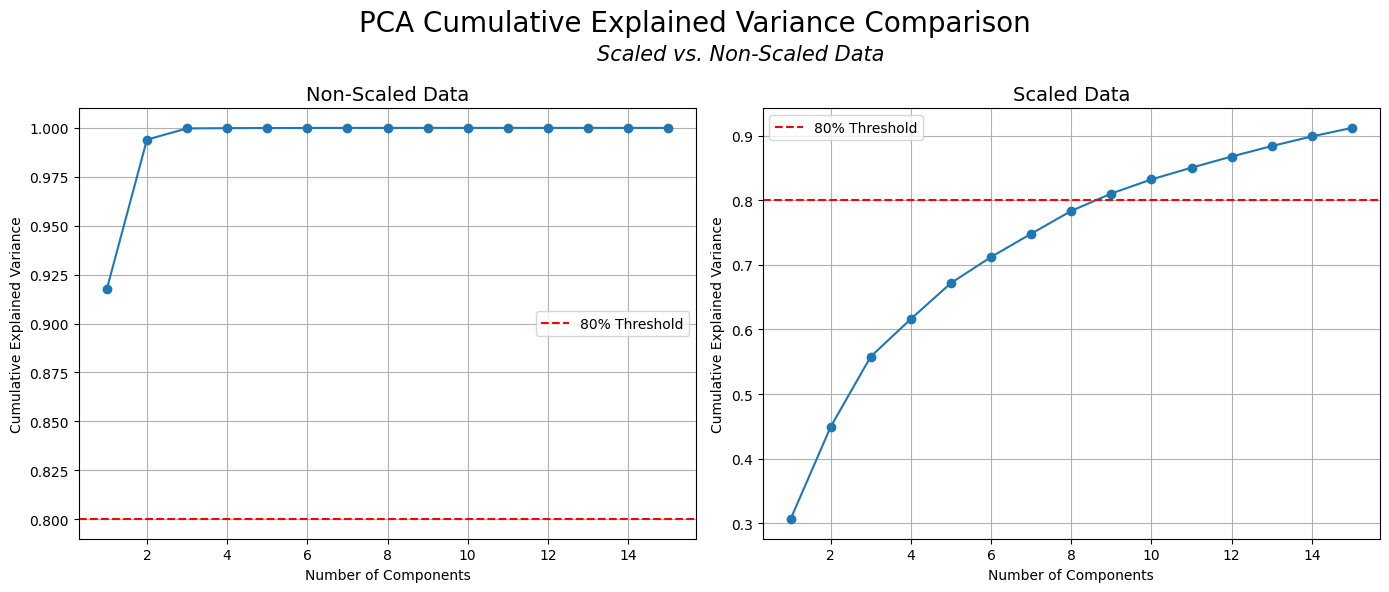

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # Set global font

# Standardize the data
X_num = data_complete.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = data_complete[['APOE4', 'PTGENDER']]  

# Raw data matrix for PCA
X_raw = data_complete.values

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1).values


# Function to compute explained variance 
def compute_explained_variance(X):
    variances = []
    for i in range(1, 16):
        pca = PCA(n_components=i)
        pca.fit(X)
        variances.append(np.sum(pca.explained_variance_ratio_))
    return variances

explained_raw = compute_explained_variance(X_raw)
explained_scaled = compute_explained_variance(X_scaled)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Non-scaled data
axes[0].plot(range(1, 16), explained_raw, marker='o', linestyle='-')
axes[0].axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
axes[0].set_title('Non-Scaled Data', fontsize=14)
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].grid(True)
axes[0].legend()

# Scaled data
axes[1].plot(range(1, 16), explained_scaled, marker='o', linestyle='-')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
axes[1].set_title('Scaled Data', fontsize=14)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].grid(True)
axes[1].legend()

fig.suptitle('PCA Cumulative Explained Variance Comparison', fontsize=20)
fig.text(0.43, 0.895, 'Scaled vs. Non-Scaled Data', fontsize=15, style='italic')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
plt.show()

In [ ]:
# Separate the categorical and numerical variables
input_cat = data_complete[['PTGENDER', 'APOE4']]
input_num = data_complete.drop(columns=['PTGENDER', 'APOE4'])

# Scale the data 
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_num)
input_scaled = pd.DataFrame(input_scaled, columns=input_num.columns)

# Concatenate scaled data with categorical variables
input = pd.concat([input_scaled, input_cat], axis=1)

In [ ]:
# Scaled input data

scores_r2 = []

for n in range(2, 11):
    print(f"Number of Components = {n}")
    r2 = cv_imputation_performance_pca(input, data_complete_missing_mask, n)
    scores_r2.append(r2)

Number of Components = 2
Fold 1: R2 = 0.521
Fold 2: R2 = 0.479
Fold 3: R2 = 0.443
Fold 4: R2 = 0.378
Fold 5: R2 = 0.491
Fold 6: R2 = 0.435
Fold 7: R2 = 0.545
Fold 8: R2 = 0.418
Fold 9: R2 = 0.363
Fold 10: R2 = 0.481
Number of Components = 3
Fold 1: R2 = 0.567
Fold 2: R2 = 0.588
Fold 3: R2 = 0.618
Fold 4: R2 = 0.559
Fold 5: R2 = 0.587
Fold 6: R2 = 0.536
Fold 7: R2 = 0.655
Fold 8: R2 = 0.523
Fold 9: R2 = 0.492
Fold 10: R2 = 0.535
Number of Components = 4
Fold 1: R2 = 0.653
Fold 2: R2 = 0.543
Fold 3: R2 = 0.600
Fold 4: R2 = 0.580
Fold 5: R2 = 0.598
Fold 6: R2 = 0.629
Fold 7: R2 = 0.687
Fold 8: R2 = 0.617
Fold 9: R2 = 0.579
Fold 10: R2 = 0.586
Number of Components = 5
Fold 1: R2 = 0.703
Fold 2: R2 = 0.591
Fold 3: R2 = 0.631
Fold 4: R2 = 0.634
Fold 5: R2 = 0.668
Fold 6: R2 = 0.660
Fold 7: R2 = 0.702
Fold 8: R2 = 0.643
Fold 9: R2 = 0.641
Fold 10: R2 = 0.586
Number of Components = 6
Fold 1: R2 = 0.682


Fold 2: R2 = 0.704
Fold 3: R2 = 0.694
Fold 4: R2 = 0.657
Fold 5: R2 = 0.681
Fold 6: R2 = 0.666
Fold 7: R2 = 0.780
Fold 8: R2 = 0.717
Fold 9: R2 = 0.706
Fold 10: R2 = 0.681
Number of Components = 7
Fold 1: R2 = 0.701
Fold 2: R2 = 0.748
Fold 3: R2 = 0.707
Fold 4: R2 = 0.689
Fold 5: R2 = 0.753
Fold 6: R2 = 0.726
Fold 7: R2 = 0.786
Fold 8: R2 = 0.741
Fold 9: R2 = 0.725
Fold 10: R2 = 0.722
Number of Components = 8
Fold 1: R2 = 0.776
Fold 2: R2 = 0.754
Fold 3: R2 = 0.784
Fold 4: R2 = 0.788
Fold 5: R2 = 0.769
Fold 6: R2 = 0.790
Fold 7: R2 = 0.845
Fold 8: R2 = 0.765
Fold 9: R2 = 0.740
Fold 10: R2 = 0.731
Number of Components = 9
Fold 1: R2 = 0.809
Fold 2: R2 = 0.790
Fold 3: R2 = 0.788
Fold 4: R2 = 0.795
Fold 5: R2 = 0.794
Fold 6: R2 = 0.812
Fold 7: R2 = 0.827
Fold 8: R2 = 0.827
Fold 9: R2 = 0.789
Fold 10: R2 = 0.793
Number of Components = 10
Fold 1: R2 = 0.802
Fold 2: R2 = 0.802
Fold 3: R2 = 0.816
Fold 4: R2 = 0.835
Fold 5: R2 = 0.828
Fold 6: R2 = 0.848
Fold 7: R2 = 0.882
Fold 8: R2 = 0.814
Fo

In [ ]:
# Non-scaled input data
scores = []
for n in range(2, 11):
    print(f"Number of Components = {n}")
    r2 = cv_imputation_performance_pca(data_complete, data_complete_missing_mask, n)
    scores.append(r2)

Number of Components = 2
Fold 1: R2 = 1.000
Fold 2: R2 = 1.000
Fold 3: R2 = 1.000
Fold 4: R2 = 1.000
Fold 5: R2 = 1.000


Fold 6: R2 = 1.000
Fold 7: R2 = 1.000
Fold 8: R2 = 1.000
Fold 9: R2 = 1.000
Fold 10: R2 = 1.000
Number of Components = 3
Fold 1: R2 = 1.000
Fold 2: R2 = 1.000
Fold 3: R2 = 1.000
Fold 4: R2 = 1.000
Fold 5: R2 = 1.000
Fold 6: R2 = 1.000
Fold 7: R2 = 1.000
Fold 8: R2 = 1.000
Fold 9: R2 = 1.000
Fold 10: R2 = 1.000
Number of Components = 4
Fold 1: R2 = 1.000
Fold 2: R2 = 1.000
Fold 3: R2 = 1.000
Fold 4: R2 = 1.000
Fold 5: R2 = 1.000
Fold 6: R2 = 1.000
Fold 7: R2 = 1.000
Fold 8: R2 = 1.000
Fold 9: R2 = 1.000
Fold 10: R2 = 1.000
Number of Components = 5
Fold 1: R2 = 1.000
Fold 2: R2 = 1.000
Fold 3: R2 = 1.000
Fold 4: R2 = 1.000
Fold 5: R2 = 1.000
Fold 6: R2 = 1.000
Fold 7: R2 = 1.000
Fold 8: R2 = 1.000
Fold 9: R2 = 1.000
Fold 10: R2 = 1.000
Number of Components = 6
Fold 1: R2 = 1.000
Fold 2: R2 = 1.000
Fold 3: R2 = 1.000
Fold 4: R2 = 1.000
Fold 5: R2 = 1.000
Fold 6: R2 = 1.000
Fold 7: R2 = 1.000
Fold 8: R2 = 1.000
Fold 9: R2 = 1.000
Fold 10: R2 = 1.000
Number of Components = 7
Fold 1: R2 = 1.

In [ ]:
scores_r2

['CV R2: 0.455 ± 0.056',
 'CV R2: 0.566 ± 0.046',
 'CV R2: 0.607 ± 0.039',
 'CV R2: 0.646 ± 0.038',
 'CV R2: 0.697 ± 0.033',
 'CV R2: 0.730 ± 0.027',
 'CV R2: 0.774 ± 0.030',
 'CV R2: 0.802 ± 0.015',
 'CV R2: 0.826 ± 0.023']

In [ ]:
scores

['CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000',
 'CV R2: 1.000 ± 0.000']

### **Training Single Model**

#### **1.1** Pre-Imputed Mean

In [ ]:
mean_df = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = mean_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mean_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Performance Evaluation

In [ ]:
cv_imputation_performance_pca(X_scaled, original_missing_mask)

Fold 1: R2 = 0.766
Fold 2: R2 = 0.775
Fold 3: R2 = 0.772
Fold 4: R2 = 0.798
Fold 5: R2 = 0.807
Fold 6: R2 = 0.813
Fold 7: R2 = 0.820
Fold 8: R2 = 0.781
Fold 9: R2 = 0.785
Fold 10: R2 = 0.791


'CV R2: 0.791 ± 0.017'

In [ ]:
cv_imputation_pca_groups(mean_df, original_missing_mask, groups, group_names)


--- Results ---
R2 subject_details: 0.987 ± 0.002
---------------------------------------------
R2 fdg_pet: 0.283 ± 0.080
---------------------------------------------
R2 nepb: 0.702 ± 0.080
---------------------------------------------
R2 av_45: 0.674 ± 0.054
---------------------------------------------
R2 csf_values: 0.982 ± 0.012
---------------------------------------------
R2 mri: 1.000 ± 0.000
---------------------------------------------


##### Create Imputed Dataset

In [ ]:
mean_df = pd.read_csv('TFG_GABRIELA_MARIN/BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

X_num = mean_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mean_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
n = 9

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

In [ ]:
pca_mean_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [ ]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_df.csv', index=False)

#### **1.2** Pre-Imputed Median

In [ ]:
median_df = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = median_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = median_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Performance Evaluation

In [ ]:
cv_imputation_performance_pca(X_scaled, original_missing_mask)

Fold 1: R2 = 0.787
Fold 2: R2 = 0.802
Fold 3: R2 = 0.805
Fold 4: R2 = 0.781
Fold 5: R2 = 0.790
Fold 6: R2 = 0.812
Fold 7: R2 = 0.820
Fold 8: R2 = 0.796
Fold 9: R2 = 0.788
Fold 10: R2 = 0.794


'CV R2: 0.798 ± 0.012'

In [ ]:
cv_imputation_pca_groups(median_df, original_missing_mask, groups, group_names)


--- Results ---
R2 subject_details: 0.987 ± 0.002
---------------------------------------------
R2 fdg_pet: 0.305 ± 0.060
---------------------------------------------
R2 nepb: 0.704 ± 0.060
---------------------------------------------
R2 av_45: 0.651 ± 0.045
---------------------------------------------
R2 csf_values: 0.986 ± 0.004
---------------------------------------------
R2 mri: 1.000 ± 0.000
---------------------------------------------


##### Create Imputed Dataset

In [ ]:
median_df = pd.read_csv('TFG_GABRIELA_MARIN/BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

X_num = median_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = median_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
n = 9

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

In [ ]:
pca_median_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [ ]:
pca_median_complete.to_csv('PCA IMPUTATION/imputed_pca_median_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_df.csv', index=False)

#### **1.3** Pre-Imputed Mode

In [ ]:
mode_df = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = mode_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mode_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Performance Evaluation

In [ ]:
cv_imputation_performance_pca(X_scaled, original_missing_mask)

Fold 1: R2 = 0.788
Fold 2: R2 = 0.781
Fold 3: R2 = 0.792
Fold 4: R2 = 0.789
Fold 5: R2 = 0.796
Fold 6: R2 = 0.792
Fold 7: R2 = 0.798
Fold 8: R2 = 0.794
Fold 9: R2 = 0.763
Fold 10: R2 = 0.794


'CV R2: 0.789 ± 0.010'

In [ ]:
cv_imputation_pca_groups(mode_df, original_missing_mask, groups, group_names)


--- Results ---
R2 subject_details: 0.986 ± 0.003
---------------------------------------------
R2 fdg_pet: 0.241 ± 0.061
---------------------------------------------
R2 nepb: 0.714 ± 0.050
---------------------------------------------
R2 av_45: 0.645 ± 0.057
---------------------------------------------
R2 csf_values: 0.976 ± 0.013
---------------------------------------------
R2 mri: 1.000 ± 0.000
---------------------------------------------


##### Create Imputed Dataset

In [ ]:
mode_df = pd.read_csv('TFG_GABRIELA_MARIN/BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

X_num = mode_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mode_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
n = 9

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

In [ ]:
pca_mode_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [ ]:
pca_mode_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_df.csv', index=False)

#### **1.4** Pre-Imputed KNN

In [ ]:
knn_df = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = knn_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = knn_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Performance Evaluation

In [ ]:
cv_imputation_performance_pca(X_scaled, original_missing_mask)

Fold 1: R2 = 0.787
Fold 2: R2 = 0.806
Fold 3: R2 = 0.773
Fold 4: R2 = 0.812
Fold 5: R2 = 0.785
Fold 6: R2 = 0.819
Fold 7: R2 = 0.823
Fold 8: R2 = 0.797
Fold 9: R2 = 0.806
Fold 10: R2 = 0.802


'CV R2: 0.801 ± 0.015'

In [ ]:
cv_imputation_pca_groups(knn_df, original_missing_mask, groups, group_names)


--- Results ---
R2 subject_details: 0.987 ± 0.003
---------------------------------------------
R2 fdg_pet: 0.285 ± 0.044
---------------------------------------------
R2 nepb: 0.664 ± 0.077
---------------------------------------------
R2 av_45: 0.660 ± 0.065
---------------------------------------------
R2 csf_values: 0.981 ± 0.010
---------------------------------------------
R2 mri: 1.000 ± 0.000
---------------------------------------------


##### Create Imputed Dataset

In [ ]:
knn_df = pd.read_csv('TFG_GABRIELA_MARIN/BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

X_num = knn_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = knn_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
n = 9

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

In [ ]:
pca_knn_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [ ]:
pca_knn_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_df.csv', index=False)

#### **1.5** Pre-Imputed Iterative

In [ ]:
iter_df = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = iter_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = iter_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Performance Evaluation

In [ ]:
cv_imputation_performance_pca(X_scaled, original_missing_mask)

Fold 1: R2 = 0.813
Fold 2: R2 = 0.819
Fold 3: R2 = 0.850
Fold 4: R2 = 0.848
Fold 5: R2 = 0.823
Fold 6: R2 = 0.842
Fold 7: R2 = 0.820
Fold 8: R2 = 0.808
Fold 9: R2 = 0.820
Fold 10: R2 = 0.812


'CV R2: 0.825 ± 0.015'

In [ ]:
cv_imputation_pca_groups(iter_df, original_missing_mask, groups, group_names)


--- Results ---
R2 subject_details: 0.987 ± 0.002
---------------------------------------------
R2 fdg_pet: 0.322 ± 0.111
---------------------------------------------
R2 nepb: 0.735 ± 0.066
---------------------------------------------
R2 av_45: 0.702 ± 0.052
---------------------------------------------
R2 csf_values: 0.984 ± 0.009
---------------------------------------------
R2 mri: 1.000 ± 0.000
---------------------------------------------


##### Create Imputed Dataset

In [ ]:
iter_df = pd.read_csv('TFG_GABRIELA_MARIN/BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

X_num = iter_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = iter_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
n = 9

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

In [ ]:
pca_iter_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [ ]:
pca_iter_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_df.csv', index=False)

#### **1.6** Pre-Imputed MICE

In [ ]:
mice_df = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = mice_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mice_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Performance Evaluation

In [ ]:
cv_imputation_performance_pca(X_scaled, original_missing_mask)

Fold 1: R2 = 0.800
Fold 2: R2 = 0.815
Fold 3: R2 = 0.805
Fold 4: R2 = 0.805
Fold 5: R2 = 0.836
Fold 6: R2 = 0.796
Fold 7: R2 = 0.806
Fold 8: R2 = 0.802
Fold 9: R2 = 0.817
Fold 10: R2 = 0.828


'CV R2: 0.811 ± 0.012'

In [ ]:
cv_imputation_pca_groups(mice_df, original_missing_mask, groups, group_names)


--- Results ---
R2 subject_details: 0.988 ± 0.002
---------------------------------------------
R2 fdg_pet: 0.349 ± 0.071
---------------------------------------------
R2 nepb: 0.699 ± 0.079
---------------------------------------------
R2 av_45: 0.680 ± 0.045
---------------------------------------------
R2 csf_values: 0.983 ± 0.014
---------------------------------------------
R2 mri: 1.000 ± 0.000
---------------------------------------------


##### Create Imputed Dataset

In [ ]:
mice_df = pd.read_csv('TFG_GABRIELA_MARIN/BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

X_num = mice_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mice_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
n = 9

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

In [ ]:
pca_mice_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [ ]:
pca_mice_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_df.csv', index=False)

##### Latent Space Extraction

In [ ]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_df.csv', index=False)

### **Training Multiple Models**

#### **1.1** Pre-Imputed Mean

In [ ]:
mean_df = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = mean_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mean_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Subject Details

In [ ]:
cv_imputation_performance_pca(X_scaled[subject_details], original_missing_mask_sd, n_components=2)

Fold 1: R2 = 0.782
Fold 2: R2 = 0.786
Fold 3: R2 = 0.762
Fold 4: R2 = 0.734
Fold 5: R2 = 0.789
Fold 6: R2 = 0.712
Fold 7: R2 = 0.831
Fold 8: R2 = 0.704
Fold 9: R2 = 0.772
Fold 10: R2 = 0.840


'CV R2: 0.771 ± 0.043'

##### FDG-PET

In [ ]:
cv_imputation_performance_pca(X_scaled[fdg_pet], original_missing_mask_fdg, n_components=2)

Fold 1: R2 = 0.891
Fold 2: R2 = 0.910
Fold 3: R2 = 0.913
Fold 4: R2 = 0.887
Fold 5: R2 = 0.934
Fold 6: R2 = 0.897
Fold 7: R2 = 0.856
Fold 8: R2 = 0.833
Fold 9: R2 = 0.873
Fold 10: R2 = 0.900


'CV R2: 0.889 ± 0.028'

##### NePB

In [ ]:
cv_imputation_performance_pca(X_scaled[nepb], original_missing_mask_nepb, n_components=2)

Fold 1: R2 = 0.720
Fold 2: R2 = 0.767
Fold 3: R2 = 0.836
Fold 4: R2 = 0.786
Fold 5: R2 = 0.767
Fold 6: R2 = 0.851
Fold 7: R2 = 0.738
Fold 8: R2 = 0.847
Fold 9: R2 = 0.753
Fold 10: R2 = 0.738


'CV R2: 0.780 ± 0.046'

##### AV-45

In [ ]:
cv_imputation_performance_pca(X_scaled[av_45], original_missing_mask_av45, n_components=2)

Fold 1: R2 = 0.934
Fold 2: R2 = 0.928
Fold 3: R2 = 0.943
Fold 4: R2 = 0.904
Fold 5: R2 = 0.909
Fold 6: R2 = 0.943
Fold 7: R2 = 0.940
Fold 8: R2 = 0.921
Fold 9: R2 = 0.950
Fold 10: R2 = 0.927


'CV R2: 0.930 ± 0.014'

##### CSF Values

In [ ]:
cv_imputation_performance_pca(X_scaled[csf_values], original_missing_mask_csf, n_components=2)

Fold 1: R2 = 0.995
Fold 2: R2 = 0.996
Fold 3: R2 = 0.997
Fold 4: R2 = 0.996
Fold 5: R2 = 0.997
Fold 6: R2 = 0.990
Fold 7: R2 = 0.995
Fold 8: R2 = 0.997
Fold 9: R2 = 0.995
Fold 10: R2 = 0.997


'CV R2: 0.996 ± 0.002'

##### MRI

In [ ]:
cv_imputation_performance_pca(X_scaled[mri], original_missing_mask_mri, n_components=2)

Fold 1: R2 = 0.770
Fold 2: R2 = 0.732
Fold 3: R2 = 0.738
Fold 4: R2 = 0.705
Fold 5: R2 = 0.716
Fold 6: R2 = 0.726
Fold 7: R2 = 0.706
Fold 8: R2 = 0.743
Fold 9: R2 = 0.753
Fold 10: R2 = 0.763


'CV R2: 0.735 ± 0.022'

#### **1.2** Pre-Imputed Median

In [ ]:
median_df = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = median_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = median_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Subject Details

In [ ]:
cv_imputation_performance_pca(X_scaled[subject_details], original_missing_mask_sd, n_components=2)

Fold 1: R2 = 0.719
Fold 2: R2 = 0.803
Fold 3: R2 = 0.754
Fold 4: R2 = 0.748
Fold 5: R2 = 0.850
Fold 6: R2 = 0.816
Fold 7: R2 = 0.808
Fold 8: R2 = 0.780
Fold 9: R2 = 0.720
Fold 10: R2 = 0.823


'CV R2: 0.782 ± 0.043'

##### FDG-PET

In [ ]:
cv_imputation_performance_pca(X_scaled[fdg_pet], original_missing_mask_fdg, n_components=2)

Fold 1: R2 = 0.896
Fold 2: R2 = 0.890
Fold 3: R2 = 0.921
Fold 4: R2 = 0.866
Fold 5: R2 = 0.878
Fold 6: R2 = 0.910
Fold 7: R2 = 0.829
Fold 8: R2 = 0.880
Fold 9: R2 = 0.868
Fold 10: R2 = 0.868


'CV R2: 0.881 ± 0.024'

##### NePB

In [ ]:
cv_imputation_performance_pca(X_scaled[nepb], original_missing_mask_nepb, n_components=2)

Fold 1: R2 = 0.769
Fold 2: R2 = 0.807
Fold 3: R2 = 0.783
Fold 4: R2 = 0.821
Fold 5: R2 = 0.770
Fold 6: R2 = 0.820
Fold 7: R2 = 0.784
Fold 8: R2 = 0.801
Fold 9: R2 = 0.716
Fold 10: R2 = 0.729


'CV R2: 0.780 ± 0.034'

##### AV-45

In [ ]:
cv_imputation_performance_pca(X_scaled[av_45], original_missing_mask_av45, n_components=2)

Fold 1: R2 = 0.940
Fold 2: R2 = 0.927
Fold 3: R2 = 0.920
Fold 4: R2 = 0.947
Fold 5: R2 = 0.932
Fold 6: R2 = 0.936
Fold 7: R2 = 0.943
Fold 8: R2 = 0.938
Fold 9: R2 = 0.945
Fold 10: R2 = 0.936


'CV R2: 0.936 ± 0.008'

##### CSF Values

In [ ]:
cv_imputation_performance_pca(X_scaled[csf_values], original_missing_mask_csf, n_components=2)

Fold 1: R2 = 0.993
Fold 2: R2 = 0.994
Fold 3: R2 = 0.997
Fold 4: R2 = 0.995
Fold 5: R2 = 0.998
Fold 6: R2 = 0.992
Fold 7: R2 = 0.996
Fold 8: R2 = 0.994
Fold 9: R2 = 0.997
Fold 10: R2 = 0.994


'CV R2: 0.995 ± 0.002'

##### MRI

In [ ]:
cv_imputation_performance_pca(X_scaled[mri], original_missing_mask_mri, n_components=2)

Fold 1: R2 = 0.739
Fold 2: R2 = 0.746
Fold 3: R2 = 0.718
Fold 4: R2 = 0.739
Fold 5: R2 = 0.765
Fold 6: R2 = 0.790
Fold 7: R2 = 0.785
Fold 8: R2 = 0.775
Fold 9: R2 = 0.768
Fold 10: R2 = 0.719


'CV R2: 0.754 ± 0.024'

#### **1.3** Pre-Imputed Mode

In [ ]:
mode_df = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = mode_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mode_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Subject Details

In [ ]:
cv_imputation_performance_pca(X_scaled[subject_details], original_missing_mask_sd, n_components=2)

Fold 1: R2 = 0.771
Fold 2: R2 = 0.739
Fold 3: R2 = 0.755
Fold 4: R2 = 0.792
Fold 5: R2 = 0.734
Fold 6: R2 = 0.761
Fold 7: R2 = 0.659
Fold 8: R2 = 0.717
Fold 9: R2 = 0.752
Fold 10: R2 = 0.809


'CV R2: 0.749 ± 0.040'

##### FDG-PET

In [ ]:
cv_imputation_performance_pca(X_scaled[fdg_pet], original_missing_mask_fdg, n_components=2)

Fold 1: R2 = 0.885
Fold 2: R2 = 0.885
Fold 3: R2 = 0.881
Fold 4: R2 = 0.830
Fold 5: R2 = 0.863
Fold 6: R2 = 0.902
Fold 7: R2 = 0.887
Fold 8: R2 = 0.884
Fold 9: R2 = 0.836
Fold 10: R2 = 0.887


'CV R2: 0.874 ± 0.022'

##### NePB

In [ ]:
cv_imputation_performance_pca(X_scaled[nepb], original_missing_mask_nepb, n_components=2)

Fold 1: R2 = 0.781
Fold 2: R2 = 0.762
Fold 3: R2 = 0.769
Fold 4: R2 = 0.835
Fold 5: R2 = 0.785
Fold 6: R2 = 0.835
Fold 7: R2 = 0.790
Fold 8: R2 = 0.797
Fold 9: R2 = 0.782
Fold 10: R2 = 0.781


'CV R2: 0.792 ± 0.024'

##### AV-45

In [ ]:
cv_imputation_performance_pca(X_scaled[av_45], original_missing_mask_av45, n_components=2)

Fold 1: R2 = 0.873
Fold 2: R2 = 0.856
Fold 3: R2 = 0.727
Fold 4: R2 = 0.833
Fold 5: R2 = 0.802
Fold 6: R2 = 0.805
Fold 7: R2 = 0.897
Fold 8: R2 = 0.844
Fold 9: R2 = 0.865
Fold 10: R2 = 0.858


'CV R2: 0.836 ± 0.046'

##### CSF Values

In [ ]:
cv_imputation_performance_pca(X_scaled[csf_values], original_missing_mask_csf, n_components=2)

Fold 1: R2 = 0.985
Fold 2: R2 = 0.971
Fold 3: R2 = 0.988
Fold 4: R2 = 0.975
Fold 5: R2 = 0.979
Fold 6: R2 = 0.990
Fold 7: R2 = 0.984
Fold 8: R2 = 0.976
Fold 9: R2 = 0.972
Fold 10: R2 = 0.989


'CV R2: 0.981 ± 0.007'

##### MRI

In [ ]:
cv_imputation_performance_pca(X_scaled[mri], original_missing_mask_mri, n_components=2)

Fold 1: R2 = 0.784
Fold 2: R2 = 0.697
Fold 3: R2 = 0.727
Fold 4: R2 = 0.783
Fold 5: R2 = 0.780
Fold 6: R2 = 0.756
Fold 7: R2 = 0.736
Fold 8: R2 = 0.732
Fold 9: R2 = 0.771
Fold 10: R2 = 0.735


'CV R2: 0.750 ± 0.028'

#### **1.4** Pre-Imputed KNN

In [ ]:
knn_df = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = knn_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = knn_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Subject Details

In [ ]:
cv_imputation_performance_pca(X_scaled[subject_details], original_missing_mask_sd, n_components=2)

Fold 1: R2 = 0.819
Fold 2: R2 = 0.765
Fold 3: R2 = 0.834
Fold 4: R2 = 0.805
Fold 5: R2 = 0.805
Fold 6: R2 = 0.752
Fold 7: R2 = 0.799
Fold 8: R2 = 0.813
Fold 9: R2 = 0.791
Fold 10: R2 = 0.809


'CV R2: 0.799 ± 0.023'

##### FDG-PET

In [ ]:
cv_imputation_performance_pca(X_scaled[fdg_pet], original_missing_mask_fdg, n_components=2)

Fold 1: R2 = 0.837
Fold 2: R2 = 0.894
Fold 3: R2 = 0.907
Fold 4: R2 = 0.819
Fold 5: R2 = 0.912
Fold 6: R2 = 0.911
Fold 7: R2 = 0.890
Fold 8: R2 = 0.880
Fold 9: R2 = 0.907
Fold 10: R2 = 0.847


'CV R2: 0.880 ± 0.032'

##### NePB

In [ ]:
cv_imputation_performance_pca(X_scaled[nepb], original_missing_mask_nepb, n_components=2)

Fold 1: R2 = 0.798
Fold 2: R2 = 0.780
Fold 3: R2 = 0.792
Fold 4: R2 = 0.805
Fold 5: R2 = 0.770
Fold 6: R2 = 0.823
Fold 7: R2 = 0.780
Fold 8: R2 = 0.779
Fold 9: R2 = 0.723
Fold 10: R2 = 0.791


'CV R2: 0.784 ± 0.025'

##### AV-45

In [ ]:
cv_imputation_performance_pca(X_scaled[av_45], original_missing_mask_av45, n_components=2)

Fold 1: R2 = 0.933
Fold 2: R2 = 0.927
Fold 3: R2 = 0.920
Fold 4: R2 = 0.948
Fold 5: R2 = 0.918
Fold 6: R2 = 0.952
Fold 7: R2 = 0.936
Fold 8: R2 = 0.920
Fold 9: R2 = 0.956
Fold 10: R2 = 0.942


'CV R2: 0.935 ± 0.013'

##### CSF Values

In [ ]:
cv_imputation_performance_pca(X_scaled[csf_values], original_missing_mask_csf, n_components=2)

Fold 1: R2 = 0.995
Fold 2: R2 = 0.991
Fold 3: R2 = 0.996
Fold 4: R2 = 0.994
Fold 5: R2 = 0.995
Fold 6: R2 = 0.995
Fold 7: R2 = 0.995
Fold 8: R2 = 0.994
Fold 9: R2 = 0.997
Fold 10: R2 = 0.995


'CV R2: 0.995 ± 0.002'

##### MRI

In [ ]:
cv_imputation_performance_pca(X_scaled[mri], original_missing_mask_mri, n_components=2)

Fold 1: R2 = 0.781
Fold 2: R2 = 0.785
Fold 3: R2 = 0.732
Fold 4: R2 = 0.734
Fold 5: R2 = 0.716
Fold 6: R2 = 0.787
Fold 7: R2 = 0.741
Fold 8: R2 = 0.797
Fold 9: R2 = 0.739
Fold 10: R2 = 0.770


'CV R2: 0.758 ± 0.027'

#### **1.5** Pre-Imputed Iterative

In [ ]:
iter_df = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = iter_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = iter_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Subject Details

In [ ]:
cv_imputation_performance_pca(X_scaled[subject_details], original_missing_mask_sd, n_components=2)

Fold 1: R2 = 0.730
Fold 2: R2 = 0.740
Fold 3: R2 = 0.801
Fold 4: R2 = 0.782
Fold 5: R2 = 0.788
Fold 6: R2 = 0.755
Fold 7: R2 = 0.632
Fold 8: R2 = 0.767
Fold 9: R2 = 0.786
Fold 10: R2 = 0.759


'CV R2: 0.754 ± 0.046'

##### FDG-PET

In [ ]:
cv_imputation_performance_pca(X_scaled[fdg_pet], original_missing_mask_fdg, n_components=2)

Fold 1: R2 = 0.874
Fold 2: R2 = 0.916
Fold 3: R2 = 0.926
Fold 4: R2 = 0.878
Fold 5: R2 = 0.905
Fold 6: R2 = 0.920
Fold 7: R2 = 0.860
Fold 8: R2 = 0.865
Fold 9: R2 = 0.861
Fold 10: R2 = 0.845


'CV R2: 0.885 ± 0.028'

##### NePB

In [ ]:
cv_imputation_performance_pca(X_scaled[nepb], original_missing_mask_nepb, n_components=2)

Fold 1: R2 = 0.790
Fold 2: R2 = 0.793
Fold 3: R2 = 0.794
Fold 4: R2 = 0.806
Fold 5: R2 = 0.836
Fold 6: R2 = 0.817
Fold 7: R2 = 0.829
Fold 8: R2 = 0.822
Fold 9: R2 = 0.744
Fold 10: R2 = 0.785


'CV R2: 0.802 ± 0.026'

##### AV-45

In [ ]:
cv_imputation_performance_pca(X_scaled[av_45], original_missing_mask_av45, n_components=2)

Fold 1: R2 = 0.908
Fold 2: R2 = 0.893
Fold 3: R2 = 0.941
Fold 4: R2 = 0.921
Fold 5: R2 = 0.907
Fold 6: R2 = 0.932
Fold 7: R2 = 0.948
Fold 8: R2 = 0.921
Fold 9: R2 = 0.948
Fold 10: R2 = 0.933


'CV R2: 0.925 ± 0.018'

##### CSF Values

In [ ]:
cv_imputation_performance_pca(X_scaled[csf_values], original_missing_mask_csf, n_components=2)

Fold 1: R2 = 0.994
Fold 2: R2 = 0.992
Fold 3: R2 = 0.996
Fold 4: R2 = 0.996
Fold 5: R2 = 0.995
Fold 6: R2 = 0.993
Fold 7: R2 = 0.994
Fold 8: R2 = 0.996
Fold 9: R2 = 0.995
Fold 10: R2 = 0.996


'CV R2: 0.995 ± 0.002'

##### MRI

In [ ]:
cv_imputation_performance_pca(X_scaled[mri], original_missing_mask_mri, n_components=2)

Fold 1: R2 = 0.832
Fold 2: R2 = 0.778
Fold 3: R2 = 0.793
Fold 4: R2 = 0.752
Fold 5: R2 = 0.764
Fold 6: R2 = 0.741
Fold 7: R2 = 0.706
Fold 8: R2 = 0.777
Fold 9: R2 = 0.784
Fold 10: R2 = 0.802


'CV R2: 0.773 ± 0.033'

#### **1.6** Pre-Imputed MICE

In [ ]:
mice_df = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])
X_num = mice_df.drop(columns=['APOE4', 'PTGENDER'])  
X_cat = mice_df[['APOE4', 'PTGENDER']]  

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

##### Subject Details

In [ ]:
cv_imputation_performance_pca(X_scaled[subject_details], original_missing_mask_sd, n_components=2)

Fold 1: R2 = 0.749
Fold 2: R2 = 0.705
Fold 3: R2 = 0.794
Fold 4: R2 = 0.830
Fold 5: R2 = 0.713
Fold 6: R2 = 0.738
Fold 7: R2 = 0.810
Fold 8: R2 = 0.678
Fold 9: R2 = 0.724
Fold 10: R2 = 0.783


'CV R2: 0.752 ± 0.047'

##### FDG-PET

In [ ]:
cv_imputation_performance_pca(X_scaled[fdg_pet], original_missing_mask_fdg, n_components=2)

Fold 1: R2 = 0.844
Fold 2: R2 = 0.829
Fold 3: R2 = 0.894
Fold 4: R2 = 0.866
Fold 5: R2 = 0.917
Fold 6: R2 = 0.904
Fold 7: R2 = 0.875
Fold 8: R2 = 0.836
Fold 9: R2 = 0.869
Fold 10: R2 = 0.855


'CV R2: 0.869 ± 0.028'

##### NePB

In [ ]:
cv_imputation_performance_pca(X_scaled[nepb], original_missing_mask_nepb, n_components=2)

Fold 1: R2 = 0.676
Fold 2: R2 = 0.782
Fold 3: R2 = 0.809
Fold 4: R2 = 0.783
Fold 5: R2 = 0.797
Fold 6: R2 = 0.841
Fold 7: R2 = 0.817
Fold 8: R2 = 0.775
Fold 9: R2 = 0.806
Fold 10: R2 = 0.786


'CV R2: 0.787 ± 0.041'

##### AV-45

In [ ]:
cv_imputation_performance_pca(X_scaled[av_45], original_missing_mask_av45, n_components=2)

Fold 1: R2 = 0.935
Fold 2: R2 = 0.941
Fold 3: R2 = 0.920
Fold 4: R2 = 0.945
Fold 5: R2 = 0.930
Fold 6: R2 = 0.935
Fold 7: R2 = 0.954
Fold 8: R2 = 0.952
Fold 9: R2 = 0.954
Fold 10: R2 = 0.938


'CV R2: 0.941 ± 0.011'

##### CSF Values

In [ ]:
cv_imputation_performance_pca(X_scaled[csf_values], original_missing_mask_csf, n_components=2)

Fold 1: R2 = 0.996
Fold 2: R2 = 0.995
Fold 3: R2 = 0.995
Fold 4: R2 = 0.996
Fold 5: R2 = 0.997
Fold 6: R2 = 0.989
Fold 7: R2 = 0.992
Fold 8: R2 = 0.997
Fold 9: R2 = 0.985
Fold 10: R2 = 0.995


'CV R2: 0.994 ± 0.004'

##### MRI

In [ ]:
cv_imputation_performance_pca(X_scaled[mri], original_missing_mask_mri, n_components=2)

Fold 1: R2 = 0.746
Fold 2: R2 = 0.778
Fold 3: R2 = 0.827
Fold 4: R2 = 0.744
Fold 5: R2 = 0.782
Fold 6: R2 = 0.768
Fold 7: R2 = 0.748
Fold 8: R2 = 0.774
Fold 9: R2 = 0.806
Fold 10: R2 = 0.741


'CV R2: 0.771 ± 0.027'

## **3.** VAE Imputation

### **VAE Architecture**

In [ ]:
class encoder(nn.Module):
    # Define the architecture of the encoder
    def __init__(self, input_dim, latent_dim=8, hidden_dims=[16, 8, 4], dropout_rate=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        prev_dim = input_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h_dim))
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            self.dropouts.append(nn.Dropout(p=dropout_rate))
            prev_dim = h_dim

        # Final layers for mean and logvar from the last hidden layer
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Sequentially add linear layer, apply batch nornalization, and dropout
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = self.relu(bn(layer(x)))
            x = dropout(x)

        # Mean and log-variance of latent distribuution
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar


    def encode_and_sample(self, x, flag_sample=True):
        mu, logvar = self.forward(x)

        # Reparametrization trick
        if flag_sample:
            logvar = torch.clamp(logvar, min=-10, max=10) # prevent numerical instability
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            sample = mu + eps * std
        else:
            sample = mu

        return mu, logvar, sample

In [ ]:
class decoder(nn.Module):
    # Define the architecture of the decoder
    def __init__(self, input_dim, latent_dim=8, hidden_dims=[4, 8, 16], dropout_rate=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        prev_dim = latent_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h_dim))
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            self.dropouts.append(nn.Dropout(p=dropout_rate))
            prev_dim = h_dim

        # Final output layers
        self.fc_mu = nn.Linear(prev_dim, input_dim)
        self.fc_logvar = nn.Linear(prev_dim, input_dim)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  

    def forward(self, z):
        # Reconstruct the observations
        for fc, bn, do in zip(self.layers, self.batch_norms, self.dropouts):
            z = self.relu(bn(fc(z)))
            z = do(z)

        recon_mu = self.sigmoid(self.fc_mu(z))      
        recon_logvar = self.fc_logvar(z)           

        return recon_mu, recon_logvar


In [ ]:
class VAE(nn.Module):  
    # Define the complete structure of the network
    def __init__(self, input_dim, latent_dim=8, epochs=30, 
                 encoder_hidden_dims=[16, 8, 4], 
                 decoder_hidden_dims=[4, 8, 16],
                 dropout_rate=0.1, 
                 device=None, lr=0.001):

        super().__init__()

        self.epochs = epochs
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr

        self.encoder = encoder(input_dim, latent_dim, hidden_dims=encoder_hidden_dims, dropout_rate=dropout_rate)
        self.decoder = decoder(input_dim, latent_dim, hidden_dims=decoder_hidden_dims, dropout_rate=dropout_rate)

        self.optim = optim.Adam(self.parameters(), lr=self.lr)
        self.to(self.device)

    def forward(self, x):
        mu_z, logvar_z, sample_z = self.encoder.encode_and_sample(x)
        mu_x, logvar_x = self.decoder(sample_z)
        return mu_x, logvar_x, mu_z, logvar_z, sample_z

    def loss_function(self, x, mu_x, logvar_x, mu_z, logvar_z):
        var_z = torch.exp(logvar_z)
        reconstruction_loss = F.mse_loss(mu_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - var_z) # closed form KL between two Gaussians
        return reconstruction_loss + kl_div, reconstruction_loss, kl_div

    # Train the network
    def trainloop(self, trainloader):
        self.train()
        for epoch in range(self.epochs):
            total_loss_train = 0
            total_rec = 0
            total_kl = 0
            for inputs in trainloader:
                inputs = inputs[0].to(self.device)
                self.optim.zero_grad()
                mu_x, logvar_x, mu_z, logvar_z, sample_z = self.forward(inputs)
                loss, rec, kl = self.loss_function(inputs, mu_x, logvar_x, mu_z, logvar_z)
                loss.backward()
                self.optim.step()
                total_loss_train += loss.item()
                total_rec += rec.item()
                total_kl += kl.item()

            #print(f"Epoch {epoch+1}/{self.epochs}, Loss: {total_loss_train/len(trainloader):.4f}, Recon: {total_rec/len(trainloader):.4f}, KL: {total_kl/len(trainloader):.4f}")
        return total_loss_train

    # Test the network
    def test(self, testloader):
        self.eval()
        total_loss_test = 0
        total_rec = 0
        total_kl = 0
        with torch.no_grad():
            for inputs in testloader:
                inputs = inputs[0].to(self.device)
                mu_x, logvar_x, mu_z, logvar_z, sample_z = self.forward(inputs)
                loss, rec, kl = self.loss_function(inputs, mu_x, logvar_x, mu_z, logvar_z)
                total_loss_test += loss.item()
                total_rec += rec.item()
                total_kl += kl.item()

        #n_batches = len(testloader)
        #print(f"Test Results - Loss: {total_loss_test/n_batches:.4f}, Recon: {total_rec/n_batches:.4f}, KL: {total_kl/n_batches:.4f}")
        return total_loss_test

### **Overall Performance**

In [ ]:
# This function calculates the overall performance obtained when imputing missing values using VAE models

def cv_imputation_vae(data, original_missing_mask, model_class, n_splits=10, batch_size=64, random_state=42, device='cpu'):
    overall_r2_scores_vae = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold=1
    for (train_idx, test_idx) in (kf.split(data)):
            print(f'Fold {fold}')

            # Divide the data
            data_train = data.iloc[train_idx].copy()
            data_test = data.iloc[test_idx].copy()

            train_missing_mask = original_missing_mask[train_idx]
            test_missing_mask = original_missing_mask[test_idx]

            # Train the VAE using only the training data
            X_train_tensor = torch.tensor(data_train.values, dtype=torch.float32).to(device)
            train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
            model = model_class(input_dim=data.shape[1], latent_dim=2).to(device)
            model.trainloop(train_loader)

            # Reconstruct the observations using the test set
            X_test_tensor = torch.tensor(data_test.values, dtype=torch.float32).to(device)
            model.eval()
            with torch.no_grad():
                mu_x, logvar_x, mu_z, logvar_z, sample_z = model.forward(X_test_tensor)
                X_reconstructed = mu_x.cpu().numpy()

            # Mask some of the observed instances in the test set
            test_known_mask = ~test_missing_mask
            total_known_values = np.sum(test_known_mask)
            missing_count = int(total_known_values * 0.2)
            possible_indices = np.argwhere(test_known_mask)
            selected_indices = possible_indices[np.random.choice(len(possible_indices), missing_count, replace=False)]
            data_test_missing = data_test.copy()
            data_test_missing.values[selected_indices[:,0], selected_indices[:,1]] = np.nan

            # Impute the masked values with the reconstructed data
            imputed = data_test_missing.copy()
            missing_mask = np.isnan(imputed.values)
            rows_with_missing = np.any(missing_mask, axis=1)
            for i in range(imputed.shape[0]):
                if rows_with_missing[i]:
                    imputed.values[i] = np.where(missing_mask[i], X_reconstructed[i], imputed.values[i])
            imputed_df = pd.DataFrame(imputed, columns=data_complete.columns)

            # Store the true and imputed values
            true_values = data_test.values[selected_indices[:,0], selected_indices[:,1]]
            predicted_values = imputed_df.values[selected_indices[:,0], selected_indices[:,1]]

            # Compute the r2 score
            r2 = r2_score(true_values, predicted_values)
            overall_r2_scores_vae.append(r2)
            fold += 1
            print(f'Fold {fold} R2 = {(r2):.3f}')

    # Return the final results 
    print("\n--- Results ---")
    print(f"Overall R2: {np.mean(overall_r2_scores_vae):.3f} ± {np.std(overall_r2_scores_vae):.3f}")
    return overall_r2_scores_vae

### **Subset Performance**

In [ ]:
# This function calculates the performance obtained when imputing missing values in specific subsets using PCA models

def cv_imputation_vae_groups(data, model_class, groups, group_names, n_splits=10, batch_size=64, random_state=42, device='cpu'):

    group_r2_scores_vae = {name: [] for name in group_names}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold = 1
    for (train_idx, test_idx) in (kf.split(data)):
        print(f'  Fold {fold}')

        # Divide the data
        data_train = data.iloc[train_idx].copy()
        data_test = data.iloc[test_idx].copy()

        # Train the VAE using the training data
        X_train_tensor = torch.tensor(data_train.values, dtype=torch.float32).to(device)
        train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
        model = model_class(input_dim=data.shape[1], latent_dim=2, device=device)
        model.trainloop(train_loader)

        # Reconstruct using the test set
        X_test_tensor = torch.tensor(data_test.values, dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            mu_x, logvar_x, mu_z, logvar_z, sample_z = model.forward(X_test_tensor)
            X_reconstructed = mu_x.cpu().numpy()

        # Impute masked values in each group
        for group, name in zip(groups, group_names):
            data_original_group = data_test[group].copy()

            # Mask some observed instances in the test set
            total_values = data_original_group.size
            missing_count = int(total_values * 0.2)
            possible_indices = np.argwhere(~np.isnan(data_original_group.values))
            selected_indices = possible_indices[np.random.choice(len(possible_indices), missing_count, replace=False)]
            data_missing_group = data_original_group.copy()
            data_missing_group.values[selected_indices[:, 0], selected_indices[:, 1]] = np.nan
            imputed_group = data_missing_group.copy()

            # Impute the masked entries using the reconstructed data
            group_indices = [data_complete.columns.get_loc(col) for col in group]
            missing_mask = np.isnan(imputed_group.values)
            rows_with_missing = np.any(missing_mask, axis=1)
            X_reconstructed_group = X_reconstructed[:, group_indices]
            for i in range(imputed_group.shape[0]):
                if rows_with_missing[i]:
                    imputed_group.values[i] = np.where(missing_mask[i], X_reconstructed_group[i], imputed_group.values[i])
            data_imputed_group = pd.DataFrame(imputed_group, columns=group)

            # Store the true and imputed values
            true_values = data_original_group.values[selected_indices[:, 0], selected_indices[:, 1]]
            imputed_values = data_imputed_group.values[selected_indices[:, 0], selected_indices[:, 1]]

            # Compute the r2 score
            r2 = r2_score(true_values, imputed_values)
            group_r2_scores_vae[name].append(r2)
            print(f'Group {name} R2 = {r2}')

        fold += 1

    # Return final results
    print("\n--- Results ---")
    for name in group_names:
        scores = group_r2_scores_vae[name]
        if scores:
            print(f"{name}: R2 {np.mean(scores):.3f} ± {np.std(scores):.3f}")
        else:
            print(f"{name}: No valid imputations")
        print('---------------------------------------------')

    return group_r2_scores_vae


### **Test VAE Configurations**

In [ ]:
# Function to perform grid search over VAE hyperparameters with with cross-validation
def grid_search_vae_cv_imputation(data, original_missing_mask, model_class, device='cpu'):

    # Define the hyperparameters to test
    latent_dims = list(range(2, 11))
    lrs = [1e-4, 1e-3, 1e-2]
    dropout_rates = [0.01, 0.05, 0.1]
    hidden_dims_sets = [[16, 8, 4], [24, 12, 6], [24, 12]]

    best_config = None
    best_r2 = -np.inf
    results = []

    # Obtain all the possible combinations
    total_combinations = list(itertools.product(latent_dims, lrs, dropout_rates, hidden_dims_sets))
    print(f"Total combinations: {len(total_combinations)}")

    # Iterate over all the configurations
    for idx, (latent_dim, lr, dropout_rate, hidden_dims) in enumerate(total_combinations, 1):
        print(f"\n[{idx}/{len(total_combinations)}] Testing config: "
              f"latent_dim={latent_dim}, lr={lr}, dropout_rate={dropout_rate}, hidden_dims={hidden_dims}")

        # Create a VAE with the hyperparameters under evaluation
        def model_factory(input_dim, latent_dim=latent_dim):
            return model_class(
                input_dim=input_dim,
                latent_dim=latent_dim,
                encoder_hidden_dims=hidden_dims,
                decoder_hidden_dims=hidden_dims[::-1],
                dropout_rate=dropout_rate,
                lr=lr,
                device=device
            )

        # Perform cross-validation for missing data imputation using the hyperparameter set under evaluation
        r2_scores = cv_imputation_vae(
            data=data,
            original_missing_mask=original_missing_mask,
            model_class=model_factory,
            n_splits=5,  # you can adjust
            batch_size=64,
            random_state=42,
            device=device
        )

        # Compute the scores
        mean_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)

        results.append({
            "latent_dim": latent_dim,
            "lr": lr,
            "dropout_rate": dropout_rate,
            "hidden_dims": hidden_dims,
            "mean_r2": mean_r2,
            "std_r2": std_r2
        })

        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_config = results[-1]

    # Return the best configuration
    print("\nBest Configuration:")
    print(best_config)

    return best_config, results

In [ ]:
# Test the combinations of hyperparameters
best_config, all_results = grid_search_vae_cv_imputation(
    data=data_complete,  
    original_missing_mask=data_complete_missing_mask,  
    model_class=VAE, 
    device='cpu'
)

Total combinations: 243

[1/243] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.01, hidden_dims=[16, 8, 4]
Fold 1
Fold 2 R2 = -0.063
Fold 2
Fold 3 R2 = -0.084
Fold 3
Fold 4 R2 = -0.074
Fold 4
Fold 5 R2 = -0.085
Fold 5
Fold 6 R2 = -0.069

--- Results ---
Overall R2: -0.075 ± 0.008

[2/243] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.01, hidden_dims=[24, 12, 6]
Fold 1
Fold 2 R2 = -0.067
Fold 2
Fold 3 R2 = -0.055
Fold 3
Fold 4 R2 = -0.059
Fold 4
Fold 5 R2 = -0.057
Fold 5
Fold 6 R2 = -0.072

--- Results ---
Overall R2: -0.062 ± 0.006

[3/243] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.01, hidden_dims=[24, 12]
Fold 1
Fold 2 R2 = -0.059
Fold 2
Fold 3 R2 = -0.067
Fold 3
Fold 4 R2 = -0.067
Fold 4
Fold 5 R2 = -0.059
Fold 5
Fold 6 R2 = -0.068

--- Results ---
Overall R2: -0.064 ± 0.004

[4/243] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.05, hidden_dims=[16, 8, 4]
Fold 1
Fold 2 R2 = -0.063
Fold 2
Fold 3 R2 = -0.073
Fold 3
Fold 4 R2 = -0.069
Fold 4
Fo

### **Scaling the Data**

In [ ]:
X_num = data_complete.drop(columns=['APOE4', 'PTGENDER']) 
X_cat = data_complete[['APOE4', 'PTGENDER']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)

input = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
cv_imputation_vae(input, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.564
Fold 2
Fold 3 R2 = -0.745
Fold 3
Fold 4 R2 = -0.646
Fold 4
Fold 5 R2 = -0.439
Fold 5
Fold 6 R2 = -0.327
Fold 6
Fold 7 R2 = -0.398
Fold 7
Fold 8 R2 = -0.667
Fold 8
Fold 9 R2 = -0.189
Fold 9
Fold 10 R2 = -0.373
Fold 10
Fold 11 R2 = -0.635

--- Results ---
Overall R2: -0.498 ± 0.170


[-0.5644875770858999,
 -0.7449060685558893,
 -0.6458452223792175,
 -0.4385973675284458,
 -0.32666657327397,
 -0.39832835846950676,
 -0.6671992175032597,
 -0.1892010118146199,
 -0.373347108197583,
 -0.6345940909820795]

### **Training Single Model**

#### **1.1** Pre-Imputed Mean

In [ ]:
mean_df = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

In [ ]:
cv_imputation_vae(mean_df, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.086
Fold 2
Fold 3 R2 = -0.102
Fold 3
Fold 4 R2 = -0.076
Fold 4
Fold 5 R2 = -0.085
Fold 5
Fold 6 R2 = -0.102
Fold 6
Fold 7 R2 = -0.075
Fold 7
Fold 8 R2 = -0.080
Fold 8
Fold 9 R2 = -0.081
Fold 9
Fold 10 R2 = -0.080
Fold 10
Fold 11 R2 = -0.087

--- Results ---
Overall R2: -0.085 ± 0.009


[-0.08605608189588887,
 -0.10217237592850825,
 -0.07568979056106628,
 -0.08464937815267182,
 -0.10233011956461291,
 -0.07470641205827877,
 -0.07956586133671828,
 -0.08116286630138925,
 -0.0804537775741132,
 -0.08681509717864011]

In [ ]:
cv_imputation_vae_groups(mean_df, VAE, groups, group_names)

  Fold 1
Group subject_details R2 = -0.47236636000118537
Group fdg_pet R2 = -3.5176275537570936
Group nepb R2 = -0.8609639419931108
Group av_45 R2 = -1.4318736769308873
Group csf_values R2 = -0.8023023340935962
Group mri R2 = -0.4128363966783648
  Fold 2
Group subject_details R2 = -0.5078151841990233
Group fdg_pet R2 = -2.512363365026683
Group nepb R2 = -0.9643249633482374
Group av_45 R2 = -1.430469224265059
Group csf_values R2 = -0.7281135248728274
Group mri R2 = -0.5520075368935062
  Fold 3
Group subject_details R2 = -0.6075646220291571
Group fdg_pet R2 = -2.873463151025498
Group nepb R2 = -0.8505588352783193
Group av_45 R2 = -1.5448806540144684
Group csf_values R2 = -0.6145177717660606
Group mri R2 = -0.4414219679878988
  Fold 4
Group subject_details R2 = -0.5475129919652337
Group fdg_pet R2 = -1.2969688978697071
Group nepb R2 = -0.8359428835045335
Group av_45 R2 = -1.516815659195109
Group csf_values R2 = -0.7698481018644756
Group mri R2 = -0.4337450563785785
  Fold 5
Group subject_

{'subject_details': [-0.47236636000118537,
  -0.5078151841990233,
  -0.6075646220291571,
  -0.5475129919652337,
  -0.5762419037095108,
  -0.5245914725102692,
  -0.49253453799343605,
  -0.6031201796867138,
  -0.5238347534206378,
  -0.5304106941300304],
 'fdg_pet': [-3.5176275537570936,
  -2.512363365026683,
  -2.873463151025498,
  -1.2969688978697071,
  -2.20312805607697,
  -2.0528127954031654,
  -2.188722990551123,
  -2.8776729503602505,
  -3.0230567149389422,
  -1.6741950971271038],
 'nepb': [-0.8609639419931108,
  -0.9643249633482374,
  -0.8505588352783193,
  -0.8359428835045335,
  -0.8668636253067339,
  -1.006144730430779,
  -1.0012685230559732,
  -0.8445499096339462,
  -0.8709288937842616,
  -0.919970154161204],
 'av_45': [-1.4318736769308873,
  -1.430469224265059,
  -1.5448806540144684,
  -1.516815659195109,
  -1.720843889473993,
  -1.3782943748180614,
  -1.340797809617631,
  -1.6580346232582102,
  -1.4070668917701514,
  -1.5046583298732954],
 'csf_values': [-0.8023023340935962,
 

#### **1.2** Pre-Imputed Median

In [ ]:
median_df = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

In [ ]:
cv_imputation_vae(median_df, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.075
Fold 2
Fold 3 R2 = -0.087
Fold 3
Fold 4 R2 = -0.087
Fold 4
Fold 5 R2 = -0.074
Fold 5
Fold 6 R2 = -0.095
Fold 6
Fold 7 R2 = -0.084
Fold 7
Fold 8 R2 = -0.100
Fold 8
Fold 9 R2 = -0.079
Fold 9
Fold 10 R2 = -0.082
Fold 10
Fold 11 R2 = -0.078

--- Results ---
Overall R2: -0.084 ± 0.008


[-0.07517928436081478,
 -0.08716448387159481,
 -0.08703238387024892,
 -0.07434027224686801,
 -0.09459500929750675,
 -0.08385011788804464,
 -0.10006161959030946,
 -0.07851156273284521,
 -0.08246877450336187,
 -0.07808271645916443]

In [ ]:
cv_imputation_vae_groups(median_df, VAE, groups, group_names)

  Fold 1
Group subject_details R2 = -0.49350200472526384
Group fdg_pet R2 = -3.490860091547403
Group nepb R2 = -0.7232429296696443
Group av_45 R2 = -1.360451096212795
Group csf_values R2 = -0.8861903856119386
Group mri R2 = -0.45480089299028914
  Fold 2
Group subject_details R2 = -0.4141662606943912
Group fdg_pet R2 = -3.21815133645653
Group nepb R2 = -1.0119902573102664
Group av_45 R2 = -1.3601336105272135
Group csf_values R2 = -0.8284971044041702
Group mri R2 = -0.37574695554994464
  Fold 3
Group subject_details R2 = -0.6047039538317072
Group fdg_pet R2 = -2.133980844805427
Group nepb R2 = -0.9900739136178305
Group av_45 R2 = -1.3242442337743143
Group csf_values R2 = -0.7456818722972576
Group mri R2 = -0.3858801309888069
  Fold 4
Group subject_details R2 = -0.37183059394856555
Group fdg_pet R2 = -1.8342034693471234
Group nepb R2 = -1.0852389850439152
Group av_45 R2 = -1.4243619498584859
Group csf_values R2 = -0.47121195066988375
Group mri R2 = -0.4281417239877461
  Fold 5
Group subje

{'subject_details': [-0.49350200472526384,
  -0.4141662606943912,
  -0.6047039538317072,
  -0.37183059394856555,
  -0.4565727309662184,
  -0.5301680291221935,
  -0.5313183115431974,
  -0.4251766412152844,
  -0.5553928699646349,
  -0.5150431272262388],
 'fdg_pet': [-3.490860091547403,
  -3.21815133645653,
  -2.133980844805427,
  -1.8342034693471234,
  -2.937384743919438,
  -2.6689149270310555,
  -2.5382027844013066,
  -3.110375776433097,
  -2.757940462380444,
  -1.7149932815310236],
 'nepb': [-0.7232429296696443,
  -1.0119902573102664,
  -0.9900739136178305,
  -1.0852389850439152,
  -0.8810023897900789,
  -0.9913313454153045,
  -0.9077004354386833,
  -0.9835491025484409,
  -0.8310756550761011,
  -0.913885237524775],
 'av_45': [-1.360451096212795,
  -1.3601336105272135,
  -1.3242442337743143,
  -1.4243619498584859,
  -1.3929789234723087,
  -1.2447277921844244,
  -1.214298611914789,
  -1.310651218891044,
  -1.2491374252882652,
  -1.3436462618444316],
 'csf_values': [-0.8861903856119386,
 

#### **1.3** Pre-Imputed Mode

In [ ]:
mode_df = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

In [ ]:
cv_imputation_vae(mode_df, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.094
Fold 2
Fold 3 R2 = -0.083
Fold 3
Fold 4 R2 = -0.083
Fold 4
Fold 5 R2 = -0.098
Fold 5
Fold 6 R2 = -0.081
Fold 6
Fold 7 R2 = -0.102
Fold 7
Fold 8 R2 = -0.074
Fold 8
Fold 9 R2 = -0.071
Fold 9
Fold 10 R2 = -0.088
Fold 10
Fold 11 R2 = -0.076

--- Results ---
Overall R2: -0.085 ± 0.010


[-0.09417606508624377,
 -0.08308828289091696,
 -0.08275374880107567,
 -0.09817668920885492,
 -0.0812515856095557,
 -0.10170477410215883,
 -0.07357714358325773,
 -0.07066659744436854,
 -0.08784011631159072,
 -0.07614492856137933]

In [ ]:
cv_imputation_vae_groups(mode_df, VAE, groups, group_names)

  Fold 1
Group subject_details R2 = -0.5238085335757583
Group fdg_pet R2 = -2.5620787093740414
Group nepb R2 = -0.8703163836174685
Group av_45 R2 = -0.7799619749409783
Group csf_values R2 = -0.5345585261786872
Group mri R2 = -0.40498489462951537
  Fold 2
Group subject_details R2 = -0.5996719379781494
Group fdg_pet R2 = -1.2485309616446156
Group nepb R2 = -0.9580207346753395
Group av_45 R2 = -0.7203250525535914
Group csf_values R2 = -0.6651031445371032
Group mri R2 = -0.36780630266456305
  Fold 3
Group subject_details R2 = -0.4113840891878642
Group fdg_pet R2 = -1.4488301579064573
Group nepb R2 = -0.8200556971817947
Group av_45 R2 = -0.7116288949125664
Group csf_values R2 = -0.7312024965533941
Group mri R2 = -0.3793146213109875
  Fold 4
Group subject_details R2 = -0.4603365590618289
Group fdg_pet R2 = -2.1867279593673743
Group nepb R2 = -0.9801775843495057
Group av_45 R2 = -0.8424437035130219
Group csf_values R2 = -0.5913758016801629
Group mri R2 = -0.33076263613941315
  Fold 5
Group su

{'subject_details': [-0.5238085335757583,
  -0.5996719379781494,
  -0.4113840891878642,
  -0.4603365590618289,
  -0.5681268906463068,
  -0.5204386631059765,
  -0.4862165111700627,
  -0.5125381137539733,
  -0.5460887317904228,
  -0.460731038194202],
 'fdg_pet': [-2.5620787093740414,
  -1.2485309616446156,
  -1.4488301579064573,
  -2.1867279593673743,
  -1.8109749879228159,
  -2.4949436709801063,
  -1.7247349247192458,
  -1.9200890732624027,
  -2.037833233946343,
  -2.04106498941864],
 'nepb': [-0.8703163836174685,
  -0.9580207346753395,
  -0.8200556971817947,
  -0.9801775843495057,
  -0.9408562214313798,
  -0.9633957506703368,
  -1.0180660082709831,
  -1.0796151518668036,
  -0.8685988275798304,
  -0.7781488451876468],
 'av_45': [-0.7799619749409783,
  -0.7203250525535914,
  -0.7116288949125664,
  -0.8424437035130219,
  -0.7331483496483922,
  -0.6939653632009841,
  -0.646878286058564,
  -0.7668204725481524,
  -0.7600710850485177,
  -0.9456412563816798],
 'csf_values': [-0.534558526178687

#### **1.4** Pre-Imputed KNN

In [ ]:
knn_df = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

In [ ]:
cv_imputation_vae(knn_df, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.087
Fold 2
Fold 3 R2 = -0.064
Fold 3
Fold 4 R2 = -0.078
Fold 4
Fold 5 R2 = -0.075
Fold 5
Fold 6 R2 = -0.075
Fold 6
Fold 7 R2 = -0.090
Fold 7
Fold 8 R2 = -0.095
Fold 8
Fold 9 R2 = -0.095
Fold 9
Fold 10 R2 = -0.086
Fold 10
Fold 11 R2 = -0.075

--- Results ---
Overall R2: -0.082 ± 0.010


[-0.08666698499542336,
 -0.06393499459174756,
 -0.07784434336176504,
 -0.07461382394843952,
 -0.07532596983675943,
 -0.09028831861079145,
 -0.09457073210665112,
 -0.09469708497130425,
 -0.08613280944925217,
 -0.07487513797908396]

In [ ]:
cv_imputation_vae_groups(knn_df, VAE, groups, group_names)

  Fold 1
Group subject_details R2 = -0.5037367402754622
Group fdg_pet R2 = -2.573547738599292
Group nepb R2 = -1.0614487944480868
Group av_45 R2 = -1.0834001384358478
Group csf_values R2 = -0.6737315570763351
Group mri R2 = -0.406050386176358
  Fold 2
Group subject_details R2 = -0.5298827249652911
Group fdg_pet R2 = -2.5771851375202792
Group nepb R2 = -1.0232603603182238
Group av_45 R2 = -1.2392695948288086
Group csf_values R2 = -0.6161286084326536
Group mri R2 = -0.3661160397730454
  Fold 3
Group subject_details R2 = -0.4779861552323055
Group fdg_pet R2 = -3.1596977194068447
Group nepb R2 = -1.0395747004916371
Group av_45 R2 = -1.2439497673597506
Group csf_values R2 = -0.5879286914539872
Group mri R2 = -0.4396634331981615
  Fold 4
Group subject_details R2 = -0.5707893070659498
Group fdg_pet R2 = -2.6381371140644347
Group nepb R2 = -0.9564867637151724
Group av_45 R2 = -1.2943228799366628
Group csf_values R2 = -0.7729083552190574
Group mri R2 = -0.4314006709926166
  Fold 5
Group subject

{'subject_details': [-0.5037367402754622,
  -0.5298827249652911,
  -0.4779861552323055,
  -0.5707893070659498,
  -0.480412900505069,
  -0.5270057051908688,
  -0.49925290553367296,
  -0.5165920412582998,
  -0.49893816188762163,
  -0.6662127088756848],
 'fdg_pet': [-2.573547738599292,
  -2.5771851375202792,
  -3.1596977194068447,
  -2.6381371140644347,
  -2.212513325977429,
  -3.268999466099915,
  -2.8340385144889924,
  -3.4335931336870757,
  -2.8479200180896806,
  -1.9699122189409297],
 'nepb': [-1.0614487944480868,
  -1.0232603603182238,
  -1.0395747004916371,
  -0.9564867637151724,
  -0.9300795649077065,
  -0.8688206526900322,
  -0.9222902866434284,
  -0.7921607013763401,
  -0.8688367706191764,
  -0.8135325747060882],
 'av_45': [-1.0834001384358478,
  -1.2392695948288086,
  -1.2439497673597506,
  -1.2943228799366628,
  -1.0279421309263013,
  -1.0096445780397807,
  -1.1418685827208934,
  -1.1341319070038192,
  -1.1173999907448597,
  -1.1204624018926919],
 'csf_values': [-0.673731557076

#### **1.5** Pre-Imputed Iterative

In [ ]:
iter_df = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

In [ ]:
cv_imputation_vae(iter_df, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.077
Fold 2
Fold 3 R2 = -0.088
Fold 3
Fold 4 R2 = -0.075
Fold 4
Fold 5 R2 = -0.097
Fold 5
Fold 6 R2 = -0.099
Fold 6
Fold 7 R2 = -0.093
Fold 7
Fold 8 R2 = -0.066
Fold 8
Fold 9 R2 = -0.086
Fold 9
Fold 10 R2 = -0.087
Fold 10
Fold 11 R2 = -0.073

--- Results ---
Overall R2: -0.084 ± 0.010


[-0.07682926606069107,
 -0.08751725155141732,
 -0.07450881552873634,
 -0.0965856574609536,
 -0.09942218803341629,
 -0.09299680506699892,
 -0.0659465538432269,
 -0.0860303780807794,
 -0.08660953068475341,
 -0.07340537401714209]

In [ ]:
cv_imputation_vae_groups(iter_df, VAE, groups, group_names)

  Fold 1
Group subject_details R2 = -0.4521902043848651
Group fdg_pet R2 = -2.2199310061183914
Group nepb R2 = -0.6952149232674107
Group av_45 R2 = -1.5476783955729783
Group csf_values R2 = -0.8413107736419925
Group mri R2 = -0.34479024003835135
  Fold 2
Group subject_details R2 = -0.4356376466238847
Group fdg_pet R2 = -2.2060942660681335
Group nepb R2 = -0.9020296900583857
Group av_45 R2 = -1.659212923944644
Group csf_values R2 = -0.6874386075027377
Group mri R2 = -0.4538909834318414
  Fold 3
Group subject_details R2 = -0.611225199863977
Group fdg_pet R2 = -1.9301762340115327
Group nepb R2 = -0.8019268922064244
Group av_45 R2 = -1.6432485341782233
Group csf_values R2 = -0.39530667095350247
Group mri R2 = -0.4853945016379535
  Fold 4
Group subject_details R2 = -0.5275321008564522
Group fdg_pet R2 = -1.3861565845541723
Group nepb R2 = -0.8794602913776839
Group av_45 R2 = -1.7059427488496337
Group csf_values R2 = -0.7830496328707397
Group mri R2 = -0.43679785074825106
  Fold 5
Group subj

{'subject_details': [-0.4521902043848651,
  -0.4356376466238847,
  -0.611225199863977,
  -0.5275321008564522,
  -0.47698131447531145,
  -0.39305441083966364,
  -0.5681588989921198,
  -0.5412235168205584,
  -0.46842566532935703,
  -0.48201429139596286],
 'fdg_pet': [-2.2199310061183914,
  -2.2060942660681335,
  -1.9301762340115327,
  -1.3861565845541723,
  -2.2307269478307643,
  -2.5576725786280234,
  -2.5427129318964043,
  -2.6569664456880258,
  -2.4091455086364935,
  -1.4948462080451668],
 'nepb': [-0.6952149232674107,
  -0.9020296900583857,
  -0.8019268922064244,
  -0.8794602913776839,
  -0.8786232517235029,
  -1.0319230607188743,
  -0.9150654552629058,
  -0.8691247865087881,
  -0.8435512921217974,
  -1.0495365910916385],
 'av_45': [-1.5476783955729783,
  -1.659212923944644,
  -1.6432485341782233,
  -1.7059427488496337,
  -1.4903960857213305,
  -1.6712063664573145,
  -1.4357256089100088,
  -1.7123211325891212,
  -1.4953704595625577,
  -1.670667264418071],
 'csf_values': [-0.841310773

#### **1.6** Pre-Imputed MICE

In [ ]:
mice_df = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

In [ ]:
cv_imputation_vae(mice_df, original_missing_mask, VAE)

Fold 1
Fold 2 R2 = -0.090
Fold 2
Fold 3 R2 = -0.105
Fold 3
Fold 4 R2 = -0.084
Fold 4
Fold 5 R2 = -0.078
Fold 5
Fold 6 R2 = -0.089
Fold 6
Fold 7 R2 = -0.078
Fold 7
Fold 8 R2 = -0.085
Fold 8
Fold 9 R2 = -0.070
Fold 9
Fold 10 R2 = -0.093
Fold 10
Fold 11 R2 = -0.070

--- Results ---
Overall R2: -0.084 ± 0.010


[-0.08996140759367144,
 -0.10460972732912888,
 -0.08448006359344218,
 -0.0781829669803098,
 -0.08864457885471677,
 -0.0784387873284289,
 -0.08487319547799643,
 -0.07000902578352197,
 -0.0930486583661565,
 -0.06994300127403896]

In [ ]:
cv_imputation_vae_groups(mice_df, VAE, groups, group_names)

  Fold 1
Group subject_details R2 = -0.550221801501056
Group fdg_pet R2 = -3.2563015234221098
Group nepb R2 = -0.92963518627478
Group av_45 R2 = -1.5082618099228573
Group csf_values R2 = -0.6842080198135907
Group mri R2 = -0.47745741756816473
  Fold 2
Group subject_details R2 = -0.4614389025987169
Group fdg_pet R2 = -2.100484545945013
Group nepb R2 = -0.7262930647270613
Group av_45 R2 = -1.4008507519475057
Group csf_values R2 = -0.8709760292762414
Group mri R2 = -0.34268291719632993
  Fold 3
Group subject_details R2 = -0.35495680553382014
Group fdg_pet R2 = -2.445369765917833
Group nepb R2 = -0.9346256456927642
Group av_45 R2 = -1.3224979580068372
Group csf_values R2 = -0.7573860263219487
Group mri R2 = -0.39395888193483364
  Fold 4
Group subject_details R2 = -0.4320099107126003
Group fdg_pet R2 = -2.224956365638173
Group nepb R2 = -0.8152496442161574
Group av_45 R2 = -1.3830211079743235
Group csf_values R2 = -0.8670162782426336
Group mri R2 = -0.4024010573460386
  Fold 5
Group subject

{'subject_details': [-0.550221801501056,
  -0.4614389025987169,
  -0.35495680553382014,
  -0.4320099107126003,
  -0.5333107946037812,
  -0.4751694125389405,
  -0.3989218047213714,
  -0.5726411496301862,
  -0.49682870492009723,
  -0.40495369061049447],
 'fdg_pet': [-3.2563015234221098,
  -2.100484545945013,
  -2.445369765917833,
  -2.224956365638173,
  -1.8831145583719757,
  -2.5404542116461535,
  -2.8842081089068543,
  -3.13604866956225,
  -2.356065440081679,
  -1.860953239864315],
 'nepb': [-0.92963518627478,
  -0.7262930647270613,
  -0.9346256456927642,
  -0.8152496442161574,
  -0.9563587712794188,
  -0.9931369307160551,
  -0.8827250559682507,
  -0.8064439204073854,
  -0.844919994509733,
  -0.9209633541500191],
 'av_45': [-1.5082618099228573,
  -1.4008507519475057,
  -1.3224979580068372,
  -1.3830211079743235,
  -1.4225118860093673,
  -1.6411879770550755,
  -1.6314334387399954,
  -1.5238938524223822,
  -1.7778323682962833,
  -1.3578656968625862],
 'csf_values': [-0.6842080198135907,


## **4.** Latent Representations

### **AGE Feature**

In [ ]:
complete = pd.read_csv('DATA/complete_data.csv')
age_whole = complete['AGE'].dropna().astype(int)

In [ ]:
all_data_gplvm = pd.read_csv('GPLVM IMPUTATION/latent_mice_df.csv')
all_data_gplvm = pd.concat([all_data_gplvm, age_whole], axis=1)
all_data_gplvm = all_data_gplvm.rename(columns={'Latent Dimension 1':'Latent Space 1', 'Latent Dimension 2':'Latent Space 2', 'AGE':'Age'})
all_data_gplvm = all_data_gplvm.dropna()

In [ ]:
# Load PCA latent space (9 components assumed)
all_data_pca = pd.read_csv('TFG_GABRIELA_MARIN/PCA IMPUTATION/imputed_pca_latent_mice_df.csv')

# Run t-SNE on PCA latent space (assumes first 9 columns are PC1 to PC9)
latent_columns = [f'PC{i}' for i in range(1, 10)]
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(all_data_pca[latent_columns])

# Add t-SNE results to DataFrame
all_data_pca['Latent Space 1'] = latent_tsne[:, 0]
all_data_pca['Latent Space 2'] = latent_tsne[:, 1]

# Add Age data
all_data_pca = pd.concat([all_data_pca, age_whole], axis=1)
all_data_pca = all_data_pca.rename(columns={'AGE': 'Age'})

# Drop missing values
all_data_pca = all_data_pca.dropna()

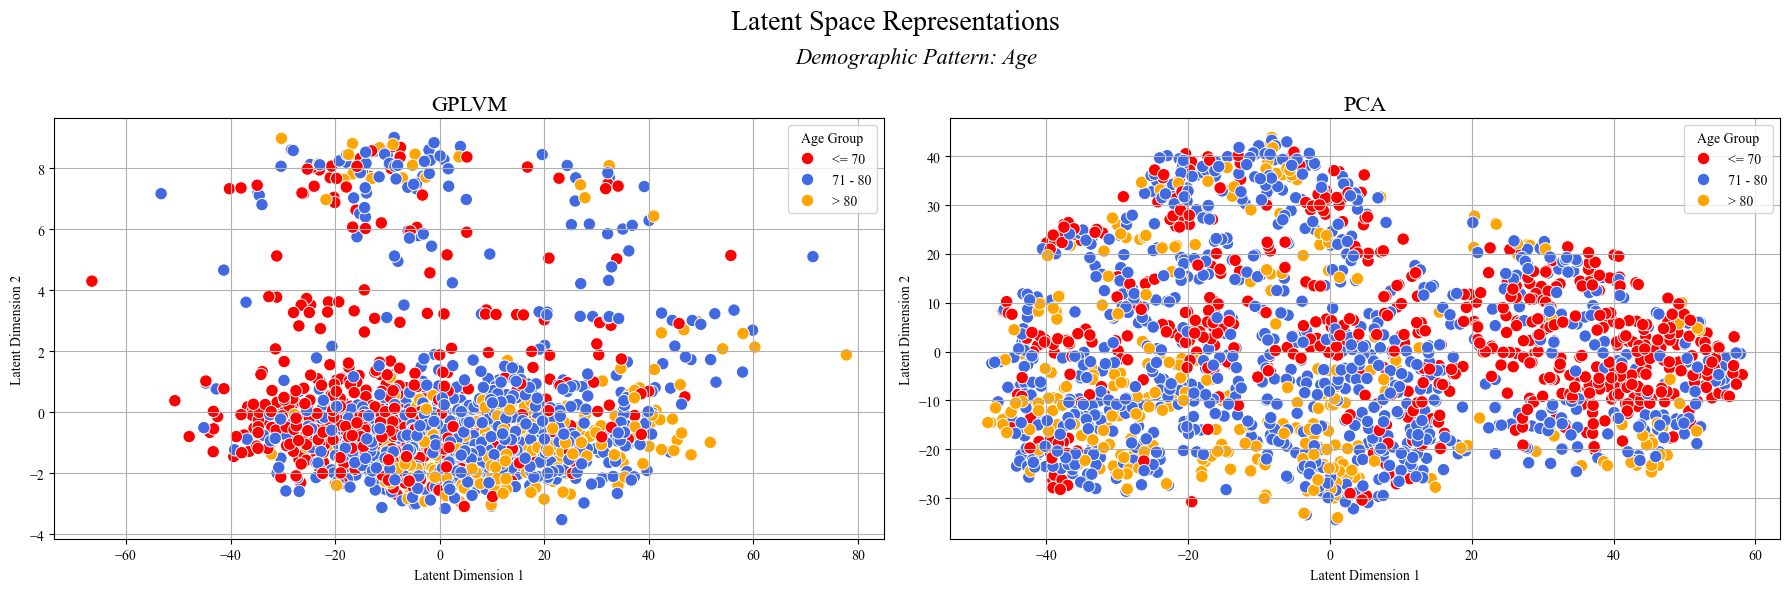

In [ ]:
# Define Age Group assignment function
def assign_age_group(age):
    if age <= 70:
        return '<= 70'
    elif 71 <= age <= 80:
        return '71 - 80'
    else:
        return '> 80'

# Assign Age Group for both datasets
for df in [all_data_gplvm, all_data_pca]:
    df['Age Group'] = df['Age'].apply(assign_age_group)

# Define consistent color mapping for age groups
custom_palette = {
    '<= 70': 'red',
    '71 - 80': 'royalblue',
    '> 80': 'orange'
}

# Plot both latent spaces with seaborn
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

datasets = [
    (all_data_gplvm, 'GPLVM'),
    (all_data_pca, 'PCA')
]

for ax, (data, title) in zip(axes, datasets):
    sns.scatterplot(
        data=data,
        x='Latent Space 1',
        y='Latent Space 2',
        hue='Age Group',
        hue_order=['<= 70', '71 - 80', '> 80'],
        palette=custom_palette,
        s=80,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()

# Titles
fig.suptitle('Latent Space Representations', fontsize=20)
fig.text(0.445, 0.89, 'Demographic Pattern: Age', style='italic', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### **SEX Feature**

In [ ]:
complete = pd.read_csv('DATA/complete_data.csv')
sex = complete['PTGENDER'].dropna().astype(int)

In [ ]:
all_data_gplvm = pd.read_csv('GPLVM IMPUTATION/latent_mice_df.csv')
all_data_gplvm = pd.concat([all_data_gplvm, sex], axis=1)
all_data_gplvm = all_data_gplvm.rename(columns={'Latent Dimension 1':'Latent Space 1', 'Latent Dimension 2':'Latent Space 2', 'PTGENDER':'Sex'})
all_data_gplvm = all_data_gplvm.dropna()

In [ ]:
# Load PCA latent space (9 components assumed)
all_data_pca = pd.read_csv('TFG_GABRIELA_MARIN/PCA IMPUTATION/imputed_pca_latent_mice_df.csv')

# Run t-SNE on PCA latent space (assumes first 9 columns are PC1 to PC9)
latent_columns = [f'PC{i}' for i in range(1, 10)]
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(all_data_pca[latent_columns])

# Add t-SNE results to DataFrame
all_data_pca['Latent Space 1'] = latent_tsne[:, 0]
all_data_pca['Latent Space 2'] = latent_tsne[:, 1]

# Add Sex data
all_data_pca = pd.concat([all_data_pca, sex], axis=1)
all_data_pca = all_data_pca.rename(columns={'PTGENDER': 'Sex'})

# Drop missing values
all_data_pca = all_data_pca.dropna()

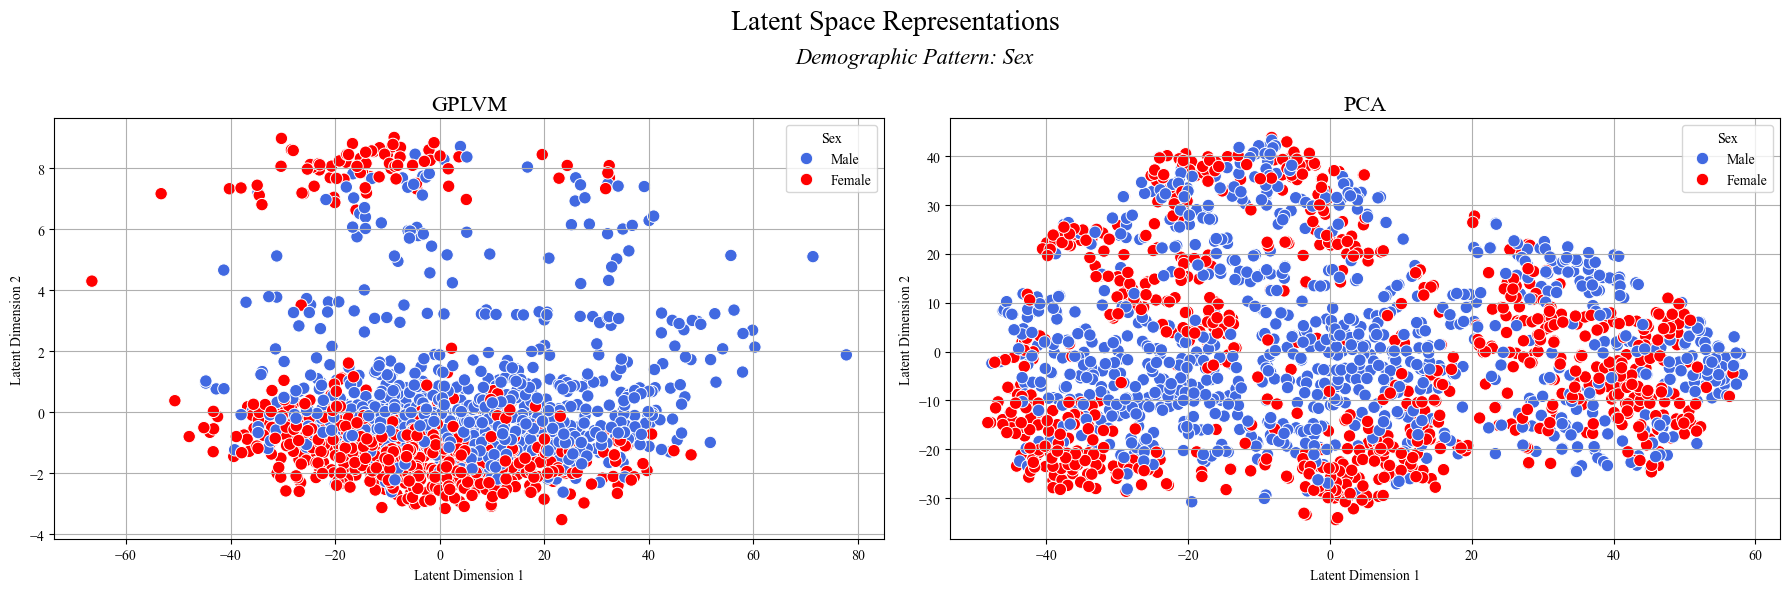

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create Age Group column for each dataframe
def assign_sex_group(sex):
    if sex == 0.0:
        return 'Male'
    else:
        return 'Female'

for df in [all_data_gplvm, all_data_pca]:
    df['Sex'] = df['Sex'].apply(assign_sex_group)

# Define consistent color mapping for age groups
custom_palette = {
    'Male': 'royalblue',
    'Female': 'red'
}

# Plot all three with seaborn in a grid
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

datasets = [
    (all_data_gplvm, 'GPLVM'),
    (all_data_pca, 'PCA')
]

for ax, (data, title) in zip(axes, datasets):
    sns.scatterplot(
        data=data,
        x='Latent Space 1',
        y='Latent Space 2',
        hue='Sex',
        palette=custom_palette,
        s=80,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

# Shared legend on top
handles, labels = axes[0].get_legend_handles_labels()

fig.suptitle('Latent Space Representations', fontsize=20)
fig.text(0.445, 0.89, 'Demographic Pattern: Sex', style = 'italic', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


### **VENTRICULAR VOLUME Feature**

In [ ]:
complete = pd.read_csv('DATA/complete_data.csv')
ventricles = complete['Ventricles'].dropna().astype(int)

In [ ]:
ventricles.min(), ventricles.max()

(5650, 145115)

In [ ]:
all_data_gplvm = pd.read_csv('GPLVM IMPUTATION/latent_mice_df.csv')
all_data_gplvm = pd.concat([all_data_gplvm, ventricles], axis=1)
all_data_gplvm = all_data_gplvm.rename(columns={'Latent Dimension 1':'Latent Space 1', 'Latent Dimension 2':'Latent Space 2', 'Ventricles':'Ventricles'})
all_data_gplvm = all_data_gplvm.dropna()

In [ ]:
# Load PCA latent space (9 components assumed)
all_data_pca = pd.read_csv('PCA IMPUTATION/imputed_pca_latent_mice_df.csv')

# Run t-SNE on PCA latent space (assumes first 9 columns are PC1 to PC9)
latent_columns = [f'PC{i}' for i in range(1, 10)]
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(all_data_pca[latent_columns])

# Add t-SNE results to DataFrame
all_data_pca['Latent Space 1'] = latent_tsne[:, 0]
all_data_pca['Latent Space 2'] = latent_tsne[:, 1]

# Add Ventricles data
all_data_pca = pd.concat([all_data_pca, ventricles], axis=1)
all_data_pca = all_data_pca.rename(columns={'Ventricles': 'Ventricles'})

# Drop missing values
all_data_pca = all_data_pca.dropna()

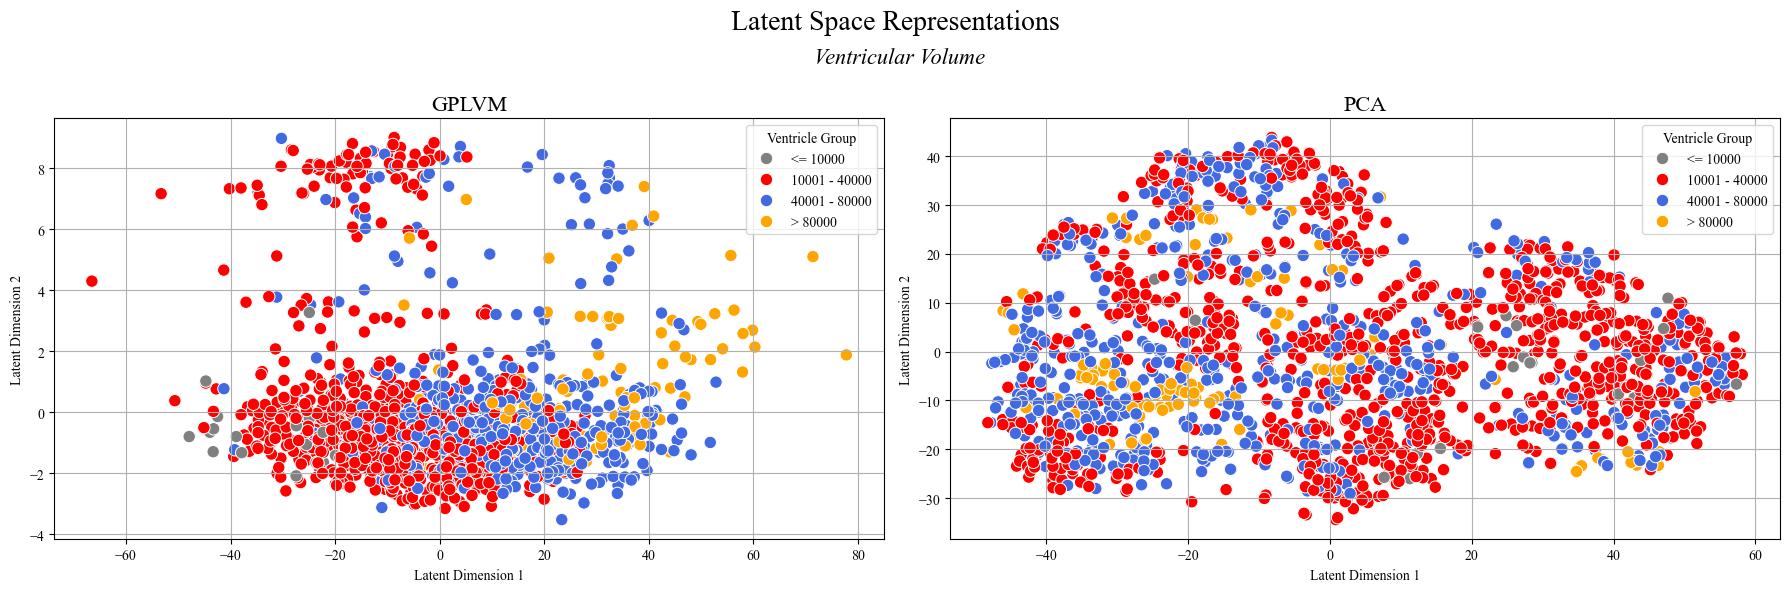

In [ ]:
def assign_ventricle_group(ventricle):
    if ventricle <= 10000:
        return '<= 10000'
    elif 10000 < ventricle <= 40000:
        return '10001 - 40000'
    elif 40000 < ventricle <= 80000:
        return '40001 - 80000'
    else:
        return '> 80000'

for df in [all_data_gplvm, all_data_pca]:
    df['Ventricle Group'] = df['Ventricles'].apply(assign_ventricle_group)

# Define consistent color mapping
custom_palette = {
    '<= 10000': 'gray',
    '10001 - 40000': 'red',
    '40001 - 80000': 'royalblue',
    '> 80000': 'orange'
}

# Updated hue order
hue_order = [
    '<= 10000',
    '10001 - 40000',
    '40001 - 80000',
    '> 80000'
]

# Plot with seaborn in a grid
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

datasets = [
    (all_data_gplvm, 'GPLVM'),
    (all_data_pca, 'PCA')
]

for ax, (data, title) in zip(axes, datasets):
    sns.scatterplot(
        data=data,
        x='Latent Space 1',
        y='Latent Space 2',
        hue='Ventricle Group',
        hue_order=hue_order,
        palette=custom_palette,
        s=80,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()

# Titles
fig.suptitle('Latent Space Representations', fontsize=20)
fig.text(0.455, 0.89, 'Ventricular Volume', style='italic', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
